In [ ]:
import tensorflow as tf
import numpy as np
import pathlib
import datetime

# printout versions
print(f"Tensor Flow Version: {tf.__version__}")
print(f"numpy Version: {np.version.version}")

Tensor Flow Version: 2.8.2
numpy Version: 1.21.6


In [ ]:
%load_ext tensorboard

In [ ]:
from keras.utils.np_utils import to_categorical

In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
import pickle, datetime
#import Preprocess as pp

import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, Convolution2D, MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing import sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import  PIL.Image

In [ ]:
luna_cancer_data = np.load('/content/drive/MyDrive/Ramasubramanya/LotusFeet/cancernodule_image_900_96_96_patches.npy')
luna_cancer_data = luna_cancer_data[:850]
print(luna_cancer_data.shape, luna_cancer_data[0].shape)

(850, 96, 96, 1) (96, 96, 1)


In [ ]:
luna_cancer_data = luna_cancer_data.reshape(850,96,96)
luna_cancer_data_rgb = np.repeat(luna_cancer_data[..., np.newaxis], 3, -1)
print(luna_cancer_data_rgb.shape, luna_cancer_data_rgb[0].shape)

(850, 96, 96, 3) (96, 96, 3)


In [ ]:
luna_non_cancer_data = np.load("/content/drive/MyDrive/Ramasubramanya/LotusFeet/non_cancernodule_image_1400_96_96_patches.npy")
luna_non_cancer_data = luna_non_cancer_data[:850]
print(luna_non_cancer_data.shape, luna_non_cancer_data[0].shape)

(850, 96, 96, 1) (96, 96, 1)


In [ ]:
luna_non_cancer_data = luna_non_cancer_data.reshape(850,96,96)
luna_non_cancer_data_rgb = np.repeat(luna_non_cancer_data[..., np.newaxis], 3, -1)
print(luna_non_cancer_data_rgb.shape, luna_non_cancer_data_rgb[0].shape)

(850, 96, 96, 3) (96, 96, 3)


In [ ]:
X_luna = np.concatenate((luna_cancer_data_rgb,luna_non_cancer_data_rgb), axis = 0)
print(X_luna.shape, X_luna[0].shape)

(1700, 96, 96, 3) (96, 96, 3)


In [ ]:
cancer_labels = np.ones(850)
noncancer_labels = np.zeros(850)
Y_luna = np.concatenate((cancer_labels,noncancer_labels), axis = 0)

In [ ]:
print(X_luna.shape, Y_luna.shape)

(1700, 96, 96, 3) (1700,)


In [ ]:
from sklearn.model_selection import train_test_split
(X_luna_train, X_luna_test, y_luna_train, y_luna_test) = train_test_split(X_luna, Y_luna,test_size=0.3, stratify=Y_luna, random_state=42)

In [ ]:
print((X_luna_train.shape, X_luna_test.shape, y_luna_train.shape, y_luna_test.shape))

((1190, 96, 96, 3), (510, 96, 96, 3), (1190,), (510,))


In [ ]:
# y_luna_train = to_categorical(y_luna_train, num_classes= 2)
# y_luna_test = to_categorical(y_luna_test, num_classes= 2)
# print(y_luna_train.shape,y_luna_test.shape)

(1190, 2) (510, 2)


In [ ]:
from tensorflow.keras.layers import Input, DepthwiseConv2D, \
     Conv2D, BatchNormalization, ReLU, AvgPool2D, Flatten, Dense

def mobilenet_block(x, filters, strides):
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

INPUT_SHAPE = 96, 96, 3

input = Input(INPUT_SHAPE)
x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)

x = mobilenet_block(x, filters=64, strides=1)

x = mobilenet_block(x, filters=128, strides=2)
x = mobilenet_block(x, filters=128, strides=1)

x = mobilenet_block(x, filters=256, strides=2)
x = mobilenet_block(x, filters=256, strides=1)

x = mobilenet_block(x, filters=512, strides=2)
for _ in range(1):
    x = mobilenet_block(x, filters=512, strides=1)
  
x = mobilenet_block(x, filters=1024, strides=2)
x = mobilenet_block(x, filters=1024, strides=1)

# x = AvgPool2D(pool_size=7, strides=1)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = Dense(units=2, activation='sigmoid')(x)

from tensorflow.keras import Model

MobileNetmodelv8forLuna = Model(inputs=input, outputs=output)

In [ ]:
MobileNetmodelv8forLuna.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 48, 48, 32)        0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 48, 48, 32)       320       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128   

In [ ]:
def train_model_mobilenet():
  
  # model = create_model()
  MobileNetmodelv8forLuna.compile(optimizer='Adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "MobileNetmodel",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  MobileNetmodelv8forLuna.fit(x=X_luna_train, 
            y=y_luna_train, 
            epochs=20, 
            validation_data=(X_luna_test, y_luna_test), 
            callbacks=[tensorboard_callback])

train_model_mobilenet()

Epoch 1/20
38/38 [==============================] - 17s 85ms/step - loss: 0.6717 - accuracy: 0.6647 - val_loss: 0.7136 - val_accuracy: 0.5000
Epoch 2/20
38/38 [==============================] - 2s 49ms/step - loss: 0.4458 - accuracy: 0.7992 - val_loss: 0.7909 - val_accuracy: 0.5000
Epoch 3/20
38/38 [==============================] - 2s 55ms/step - loss: 0.2638 - accuracy: 0.8933 - val_loss: 0.8983 - val_accuracy: 0.5000
Epoch 4/20
38/38 [==============================] - 2s 49ms/step - loss: 0.1610 - accuracy: 0.9395 - val_loss: 0.9896 - val_accuracy: 0.5000
Epoch 5/20
38/38 [==============================] - 2s 50ms/step - loss: 0.1371 - accuracy: 0.9437 - val_loss: 1.1951 - val_accuracy: 0.5000
Epoch 6/20
38/38 [==============================] - 2s 51ms/step - loss: 0.0994 - accuracy: 0.9630 - val_loss: 1.2713 - val_accuracy: 0.5000
Epoch 7/20
38/38 [==============================] - 2s 50ms/step - loss: 0.1600 - accuracy: 0.9412 - val_loss: 1.4861 - val_accuracy: 0.5000
Epoch 8/20
3

In [ ]:
def train_model_mobilenet():
  
  # model = create_model()
  MobileNetmodelv8forLuna.compile(optimizer='Adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "MobileNetmodel",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  MobileNetmodelv8forLuna.fit(x=X_luna_train, 
            y=y_luna_train, 
            epochs=20, 
            validation_data=(X_luna_test, y_luna_test), 
            callbacks=[tensorboard_callback])

train_model_mobilenet()

Epoch 1/20
38/38 [==============================] - 16s 72ms/step - loss: 0.6861 - accuracy: 0.6571 - val_loss: 0.7091 - val_accuracy: 0.5000
Epoch 2/20
38/38 [==============================] - 2s 46ms/step - loss: 0.4280 - accuracy: 0.8168 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/20
38/38 [==============================] - 2s 46ms/step - loss: 0.2840 - accuracy: 0.8882 - val_loss: 0.6945 - val_accuracy: 0.5000
Epoch 4/20
38/38 [==============================] - 2s 47ms/step - loss: 0.2424 - accuracy: 0.9168 - val_loss: 0.7349 - val_accuracy: 0.5000
Epoch 5/20
38/38 [==============================] - 2s 46ms/step - loss: 0.2343 - accuracy: 0.9000 - val_loss: 0.6956 - val_accuracy: 0.5000
Epoch 6/20
38/38 [==============================] - 2s 46ms/step - loss: 0.1608 - accuracy: 0.9311 - val_loss: 0.6977 - val_accuracy: 0.5000
Epoch 7/20
38/38 [==============================] - 2s 46ms/step - loss: 0.1059 - accuracy: 0.9639 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 8/20
3

In [ ]:
def train_model_mobilenet():
  
  # model = create_model()
  MobileNetmodelv8forLuna.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "MobileNetmodel",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  MobileNetmodelv8forLuna.fit(x=X_luna_train, 
            y=y_luna_train, 
            epochs=20, 
            validation_data=(X_luna_test, y_luna_test), 
            callbacks=[tensorboard_callback])

train_model_mobilenet()

Epoch 1/20
38/38 [==============================] - 16s 78ms/step - loss: 0.6546 - accuracy: 0.6218 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 2/20
38/38 [==============================] - 2s 47ms/step - loss: 0.5265 - accuracy: 0.7311 - val_loss: 0.6962 - val_accuracy: 0.5000
Epoch 3/20
38/38 [==============================] - 2s 48ms/step - loss: 0.4535 - accuracy: 0.7731 - val_loss: 0.6966 - val_accuracy: 0.5000
Epoch 4/20
38/38 [==============================] - 2s 48ms/step - loss: 0.4026 - accuracy: 0.8059 - val_loss: 0.7463 - val_accuracy: 0.5000
Epoch 5/20
38/38 [==============================] - 2s 48ms/step - loss: 0.3664 - accuracy: 0.8227 - val_loss: 0.7068 - val_accuracy: 0.5000
Epoch 6/20
38/38 [==============================] - 2s 47ms/step - loss: 0.3753 - accuracy: 0.8277 - val_loss: 0.9186 - val_accuracy: 0.5000
Epoch 7/20
38/38 [==============================] - 2s 48ms/step - loss: 0.3463 - accuracy: 0.8513 - val_loss: 0.9677 - val_accuracy: 0.5000
Epoch 8/20
3

In [ ]:
def train_model_mobilenet():
  
  # model = create_model()
  MobileNetmodelv8forLuna.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "MobileNetmodel",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  MobileNetmodelv8forLuna.fit(x=X_luna_train, 
            y=y_luna_train, 
            epochs=20, 
            validation_data=(X_luna_test, y_luna_test), 
            callbacks=[tensorboard_callback])

train_model_mobilenet()

Epoch 1/20
38/38 [==============================] - 6s 77ms/step - loss: 0.6179 - accuracy: 0.6613 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/20
38/38 [==============================] - 2s 54ms/step - loss: 0.5041 - accuracy: 0.7311 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 3/20
38/38 [==============================] - 2s 54ms/step - loss: 0.4523 - accuracy: 0.7891 - val_loss: 0.6962 - val_accuracy: 0.5000
Epoch 4/20
38/38 [==============================] - 2s 55ms/step - loss: 0.4212 - accuracy: 0.8017 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/20
38/38 [==============================] - 2s 55ms/step - loss: 0.4047 - accuracy: 0.8000 - val_loss: 0.7109 - val_accuracy: 0.5000
Epoch 6/20
38/38 [==============================] - 2s 55ms/step - loss: 0.3459 - accuracy: 0.8513 - val_loss: 0.7097 - val_accuracy: 0.5000
Epoch 7/20
38/38 [==============================] - 2s 55ms/step - loss: 0.3024 - accuracy: 0.8689 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 8/20
38

In [ ]:
pip install visualkeras 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 3.9 MB/s 


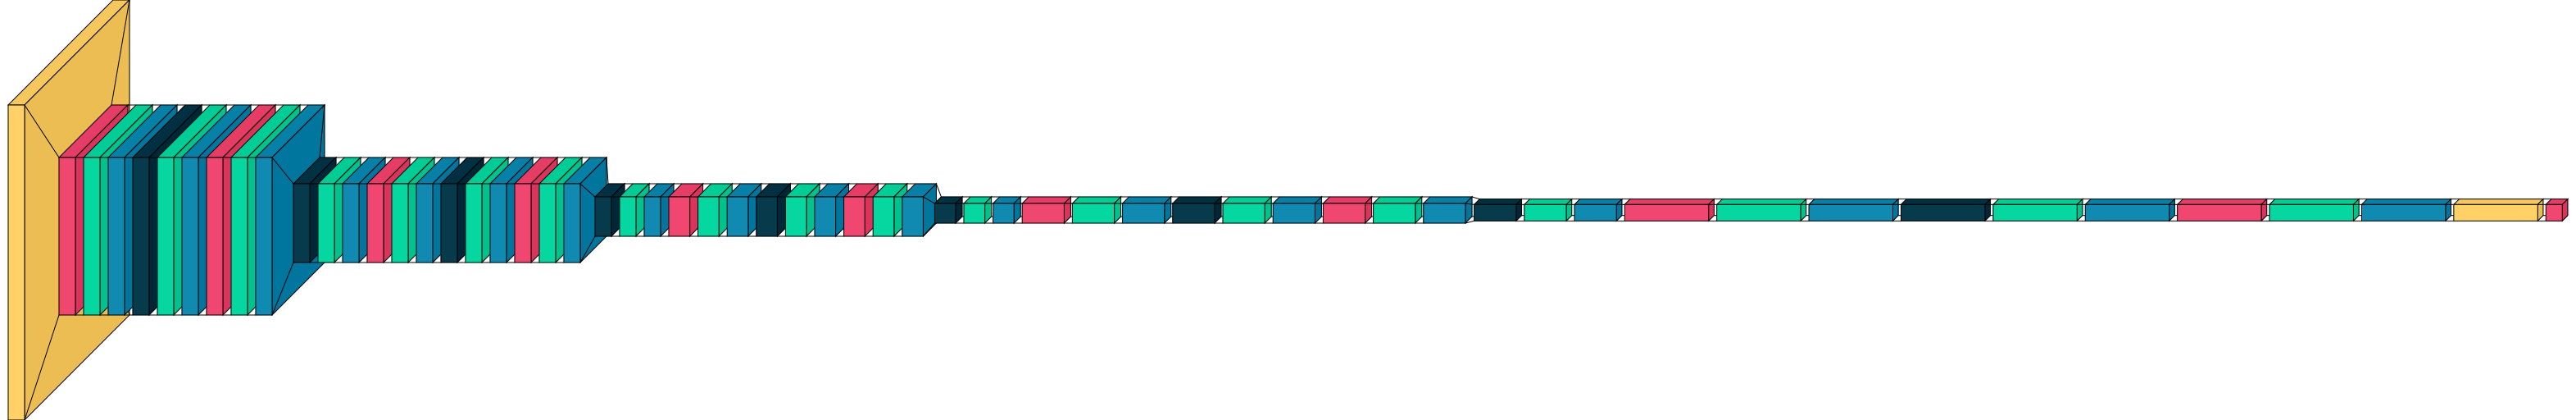

In [ ]:
import visualkeras
visualkeras.layered_view(MobileNetmodelv8forLuna)

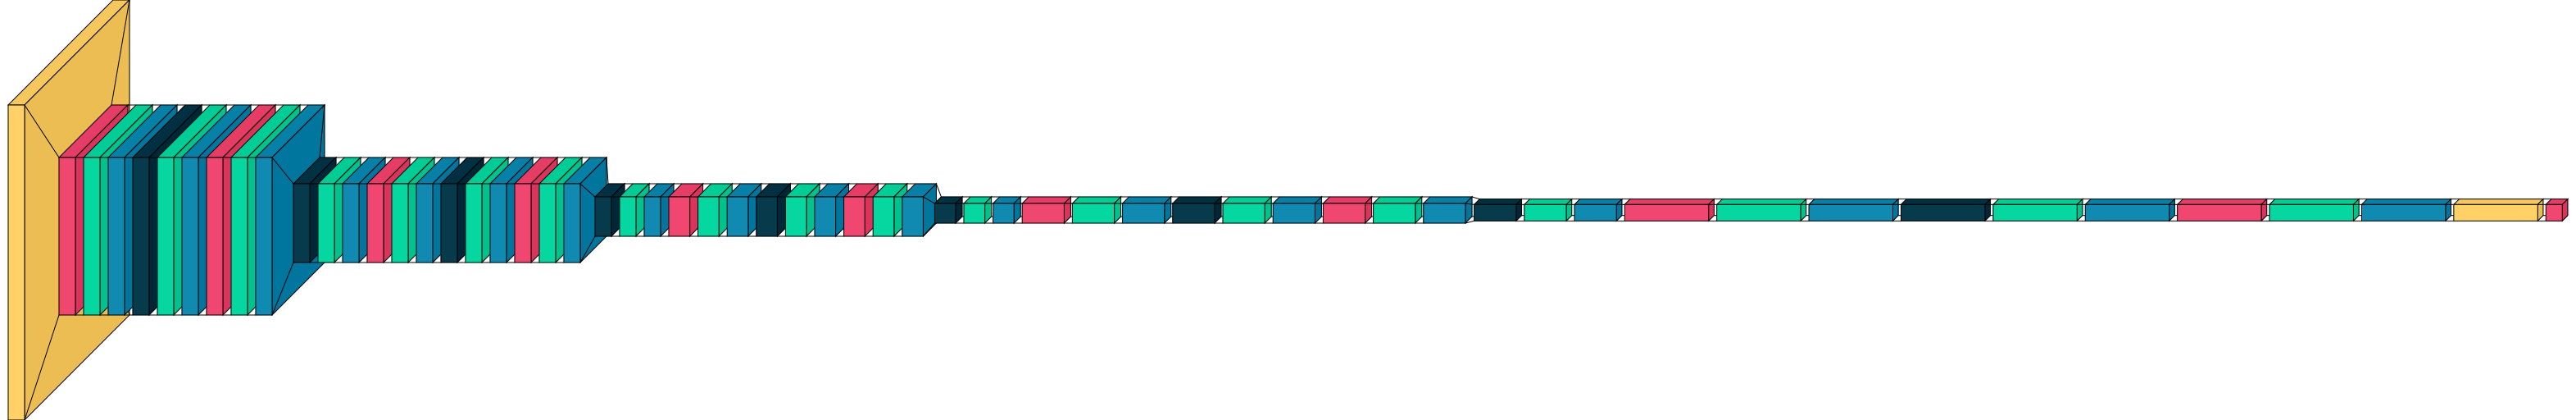

In [ ]:
import visualkeras
visualkeras.layered_view(MobileNetmodelv8forLuna)

In [ ]:
def train_model_mobilenet():
  
  # model = create_model()
  MobileNetmodelv8_GAN.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "MobileNetmodel",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  MobileNetmodelv8_GAN.fit(x=X_luna_train, 
            y=y_luna_train, 
            epochs=20, 
            validation_data=(X_luna_test, y_luna_test), 
            callbacks=[tensorboard_callback])

train_model_mobilenet()

Epoch 1/20
38/38 [==============================] - 17s 100ms/step - loss: 0.7013 - accuracy: 0.5521 - val_loss: 0.6948 - val_accuracy: 0.5000
Epoch 2/20
38/38 [==============================] - 3s 70ms/step - loss: 0.5706 - accuracy: 0.6891 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 3/20
38/38 [==============================] - 3s 68ms/step - loss: 0.5016 - accuracy: 0.7597 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/20
38/38 [==============================] - 3s 68ms/step - loss: 0.5015 - accuracy: 0.7412 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 5/20
38/38 [==============================] - 3s 68ms/step - loss: 0.4527 - accuracy: 0.7840 - val_loss: 0.7084 - val_accuracy: 0.5000
Epoch 6/20
38/38 [==============================] - 3s 68ms/step - loss: 0.4069 - accuracy: 0.8092 - val_loss: 0.6984 - val_accuracy: 0.5000
Epoch 7/20
38/38 [==============================] - 3s 68ms/step - loss: 0.3876 - accuracy: 0.8345 - val_loss: 0.6962 - val_accuracy: 0.5000
Epoch 8/20


In [ ]:
# extract the predicted probabilities
p_pred_train = MobileNetmodelv8forLuna.predict(X_luna_train)

In [ ]:
y_pred_train = np.where(p_pred_train > 0.5, 1, 0)
print(y_pred_train)

[[1 0]
 [0 1]
 [1 0]
 ...
 [1 0]
 [1 0]
 [0 1]]


In [ ]:
y_luna_train = to_categorical(y_luna_train, num_classes= 2)

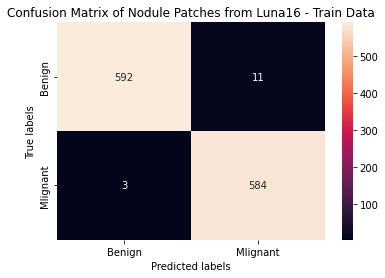

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['Benign','Mlignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_train).argmax(axis=1), np.asarray(y_luna_train).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Nodule Patches from Luna16 - Train Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

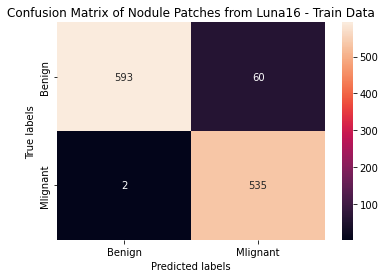

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['Benign','Mlignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_train).argmax(axis=1), np.asarray(y_luna_train).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Nodule Patches from Luna16 - Train Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
# extract the predicted probabilities
p_pred_test = MobileNetmodelv8forLuna.predict(X_luna_test)

In [ ]:
y_pred_test = np.where(p_pred_test > 0.5, 1, 0)
print(y_pred_test)

[[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [1 0]]


In [ ]:
y_luna_test = to_categorical(y_luna_test, num_classes= 2)

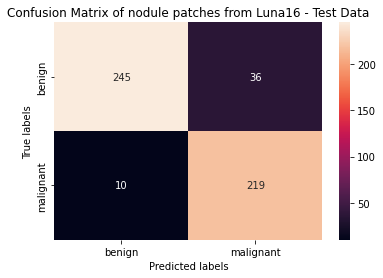

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_test).argmax(axis=1), np.asarray(y_luna_test).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of nodule patches from Luna16 - Test Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

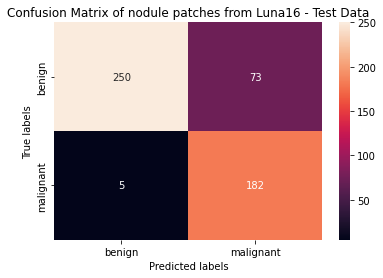

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_test).argmax(axis=1), np.asarray(y_luna_test).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of nodule patches from Luna16 - Test Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
luna_cancer_data = np.load('/content/drive/MyDrive/Ramasubramanya/LotusFeet/cancernodule_image_900_96_96_patches.npy')
testing_luna_cancer_data = luna_cancer_data[850:]
print(testing_luna_cancer_data.shape, testing_luna_cancer_data[0].shape)

(50, 96, 96, 1) (96, 96, 1)


In [ ]:
testing_luna_cancer_data = testing_luna_cancer_data.reshape(50,96,96)
testing_luna_cancer_data_rgb = np.repeat(testing_luna_cancer_data[..., np.newaxis], 3, -1)
print(testing_luna_cancer_data_rgb.shape, testing_luna_cancer_data_rgb[0].shape)

(50, 96, 96, 3) (96, 96, 3)


In [ ]:
luna_non_cancer_data = np.load("/content/drive/MyDrive/Ramasubramanya/LotusFeet/non_cancernodule_image_1400_96_96_patches.npy")
testing_luna_non_cancer_data = luna_non_cancer_data[850:900]
print(testing_luna_non_cancer_data.shape, testing_luna_non_cancer_data[0].shape)

(50, 96, 96, 1) (96, 96, 1)


In [ ]:
testing_luna_non_cancer_data = testing_luna_non_cancer_data.reshape(50,96,96)
testing_luna_non_cancer_data_rgb = np.repeat(testing_luna_non_cancer_data[..., np.newaxis], 3, -1)
print(testing_luna_non_cancer_data_rgb.shape, testing_luna_non_cancer_data_rgb[0].shape)

(50, 96, 96, 3) (96, 96, 3)


In [ ]:
X_lunas = np.concatenate((testing_luna_cancer_data_rgb,testing_luna_non_cancer_data_rgb), axis = 0)
print(X_lunas.shape, X_lunas[0].shape)

(100, 96, 96, 3) (96, 96, 3)


In [ ]:
testing_cancer_labels = np.ones(50)
testing_noncancer_labels = np.zeros(50)
Y_lunas = np.concatenate((testing_cancer_labels,testing_noncancer_labels), axis = 0)

In [ ]:
# extract the predicted probabilities
p_pred_tests = MobileNetmodelv8forLuna.predict(X_lunas)

In [ ]:
y_pred_tests = np.where(p_pred_tests > 0.5, 1, 0)
print(y_pred_tests)

[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]


In [ ]:
Y_lunas = to_categorical(Y_lunas, num_classes= 2)

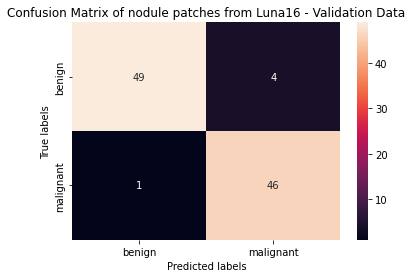

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_tests).argmax(axis=1), np.asarray(Y_lunas).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of nodule patches from Luna16 - Validation Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

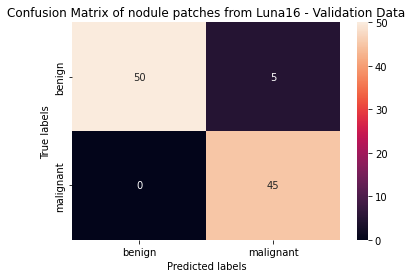

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_tests).argmax(axis=1), np.asarray(Y_lunas).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of nodule patches from Luna16 - Validation Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

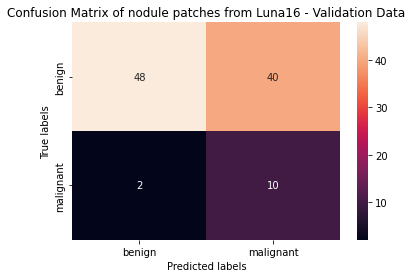

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_tests).argmax(axis=1), np.asarray(Y_lunas).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of nodule patches from Luna16 - Validation Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = MobileNetmodelv8forLuna.predict(X_luna_train)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(np.asarray(y_luna_train).argmax(axis=1), np.asarray(y_pred_keras).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
from sklearn.metrics import roc_curve
y_test_keras = MobileNetmodelv8forLuna.predict(X_luna_test)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(np.asarray(y_luna_test).argmax(axis=1), np.asarray(y_test_keras).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_rf = auc(fpr_rf, tpr_rf)

In [ ]:
from sklearn.metrics import roc_curve
y_pred_s = MobileNetmodelv8forLuna.predict(X_lunas)
fpr_rff, tpr_rff, thresholds_rf = roc_curve(np.asarray(Y_lunas).argmax(axis=1), np.asarray(y_pred_s).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_rff = auc(fpr_rff, tpr_rff)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_luna_train, axis=1), np.argmax(y_pred_train, axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       595
           1       0.99      0.98      0.99       595

    accuracy                           0.99      1190
   macro avg       0.99      0.99      0.99      1190
weighted avg       0.99      0.99      0.99      1190



In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_luna_test, axis=1), np.argmax(p_pred_test, axis=1)))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       255
           1       0.95      0.86      0.90       255

    accuracy                           0.91       510
   macro avg       0.91      0.91      0.91       510
weighted avg       0.91      0.91      0.91       510



In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_lunas, axis=1), np.argmax(y_pred_s, axis=1)))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        50
           1       0.98      0.92      0.95        50

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



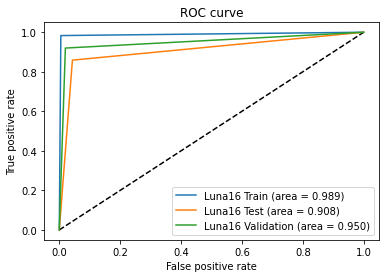

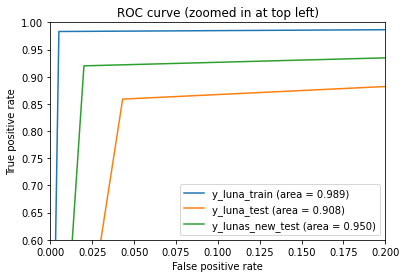

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Luna16 Train (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='Luna16 Test (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_rff, tpr_rff, label='Luna16 Validation (area = {:.3f})'.format(auc_rff))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0,0.2)
plt.ylim(0.6,1.0)
plt.plot([0, 2], [0, 2], 'k--')
plt.plot(fpr_keras, tpr_keras, label='y_luna_train (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='y_luna_test (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_rff, tpr_rff, label='y_lunas_new_test (area = {:.3f})'.format(auc_rff))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve
p_pred_train = MobileNetmodelv8forLuna.predict(X_luna_train)
fpr_train, tpr_train, thresholds_train = roc_curve(np.asarray(y_luna_train).argmax(axis=1), np.asarray(p_pred_train).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_train, tpr_train)

In [ ]:
fpr_train = dict()
tpr_train = dict()
roc_auc = dict()
for i in range(2):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_luna_train[:, i], p_pred_train[:, i])
    roc_auc[i] = auc(fpr_train[i], tpr_train[i])

# Compute micro-average ROC curve and ROC area
# fpr_train["micro"], tpr_train["micro"], _ = roc_curve(y_luna_train.ravel(), p_pred_train.ravel())
# roc_auc["micro"] = auc(fpr_train["micro"], tpr_train["micro"])

In [ ]:
from sklearn.metrics import roc_curve
p_pred_test = MobileNetmodelv8forLuna.predict(X_luna_test)
fpr_test, tpr_test, thresholds_rf = roc_curve(np.asarray(y_luna_test).argmax(axis=1), np.asarray(p_pred_test).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_rf = auc(fpr_test, tpr_test)

In [ ]:
fpr_te = dict()
tpr_te = dict()
roc_auc_te = dict()
for i in range(2):
    fpr_te[i], tpr_te[i], _ = roc_curve(y_luna_test[:, i], p_pred_test[:, i])
    roc_auc_te[i] = auc(fpr_te[i], tpr_te[i])

# Compute micro-average ROC curve and ROC area
# fpr_te["micro"], tpr_te["micro"], _ = roc_curve(y_luna_test.ravel(), p_pred_test.ravel())
# roc_auc_te["micro"] = auc(fpr_te["micro"], tpr_te["micro"])


In [ ]:
from sklearn.metrics import roc_curve
p_pred_val = MobileNetmodelv8forLuna.predict(X_lunas)
fpr_rff, tpr_rff, thresholds_rf = roc_curve(np.asarray(Y_lunas).argmax(axis=1), np.asarray(p_pred_val).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_rff = auc(fpr_rff, tpr_rff)

In [ ]:
fpr_va = dict()
tpr_va = dict()
roc_auc_va = dict()
for i in range(2):
    fpr_va[i], tpr_va[i], _ = roc_curve(Y_lunas[:, i], p_pred_val[:, i])
    roc_auc[i] = auc(fpr_va[i], fpr_va[i])

# Compute micro-average ROC curve and ROC area
# fpr_va["micro"], tpr_va["micro"], _ = roc_curve(Y_lunas.ravel(), p_pred_val.ravel())
# roc_auc_va["micro"] = auc(fpr_va["micro"], tpr_va["micro"])

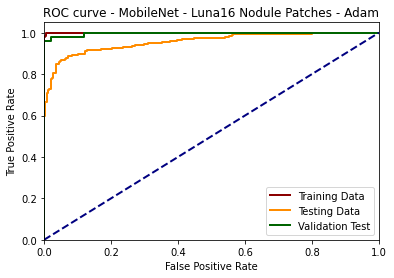

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr_train[1],
    tpr_train[1],
    color="darkred",
    lw=lw,
    label="Training Data" ,
)
plt.plot(
    fpr_te[1],
    tpr_te[1],
    color="darkorange",
    lw=lw,
    label="Testing Data",
)
plt.plot(
    fpr_va[0],
    tpr_va[0],
    color="darkgreen",
    lw=lw,
    label="Validation Test",
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - MobileNet - Luna16 Nodule Patches - Adam")
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_luna_train, axis=1), np.argmax(y_pred_train, axis=1)))

from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_luna_test, axis=1), np.argmax(p_pred_test, axis=1)))

from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_lunas, axis=1), np.argmax(p_pred_val, axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       595
           1       0.99      0.98      0.99       595

    accuracy                           0.99      1190
   macro avg       0.99      0.99      0.99      1190
weighted avg       0.99      0.99      0.99      1190

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       255
           1       0.95      0.86      0.90       255

    accuracy                           0.91       510
   macro avg       0.91      0.91      0.91       510
weighted avg       0.91      0.91      0.91       510

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        50
           1       0.98      0.92      0.95        50

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



In [ ]:
GAN_Noncancer = np.load('/content/drive/My Drive/yazy/noncancer_lung_04Jun/output/generated_noncancer_nodules_2k_96x96.npy')
GAN_Cancer = np.load('/content/drive/MyDrive/yazy/cancer_lung_29May/output/generated_cancer_nodules_2k_96x96.npy')
print(GAN_Cancer.shape,GAN_Noncancer.shape,GAN_Cancer[0].shape,GAN_Noncancer[0].shape)

(2000, 96, 96, 3) (2000, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
GAN_Cancer = GAN_Cancer[:1700]
GAN_Noncancer = GAN_Noncancer[:1700]
print(GAN_Cancer.shape,GAN_Noncancer.shape,GAN_Cancer[0].shape,GAN_Noncancer[0].shape)

(1700, 96, 96, 3) (1700, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
X_GAN = np.concatenate((GAN_Cancer, GAN_Noncancer), axis = 0)
Y_GAN = np.concatenate((np.ones(1700), np.zeros(1700)), axis = 0)
print(X_GAN.shape, Y_GAN.shape)

(3400, 96, 96, 3) (3400,)


In [ ]:
from sklearn.model_selection import train_test_split
(X_GANtrain, X_GANtest, y_GANtrain, y_GANtest) = train_test_split(X_GAN, Y_GAN,test_size=0.3, stratify=Y_GAN, random_state=42)

In [ ]:
print(X_GANtrain.shape, X_GANtest.shape, y_GANtrain.shape, y_GANtest.shape)

(2380, 96, 96, 3) (1020, 96, 96, 3) (2380,) (1020,)


In [ ]:
from tensorflow.keras.layers import Input, DepthwiseConv2D, \
     Conv2D, BatchNormalization, ReLU, AvgPool2D, Flatten, Dense

def mobilenet_block(x, filters, strides):
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

INPUT_SHAPE = 96, 96, 3

input = Input(INPUT_SHAPE)
x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)

x = mobilenet_block(x, filters=64, strides=1)

x = mobilenet_block(x, filters=128, strides=2)
x = mobilenet_block(x, filters=128, strides=1)

x = mobilenet_block(x, filters=256, strides=2)
x = mobilenet_block(x, filters=256, strides=1)

x = mobilenet_block(x, filters=512, strides=2)
for _ in range(1):
    x = mobilenet_block(x, filters=512, strides=1)
  
x = mobilenet_block(x, filters=1024, strides=2)
x = mobilenet_block(x, filters=1024, strides=1)

# x = AvgPool2D(pool_size=7, strides=1)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = Dense(units=2, activation='sigmoid')(x)

from tensorflow.keras import Model

MobileNetmodelv8forGAN = Model(inputs=input, outputs=output)

In [ ]:
def train_model_mobilenet():
  
  # model = create_model()
  MobileNetmodelv8forGAN.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "MobileNetmodel_v1",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  MobileNetmodelv8forGAN.fit(x=X_GANtrain, 
            y=y_GANtrain, 
            epochs=20, 
            validation_data=(X_GANtest, y_GANtest), 
            callbacks=[tensorboard_callback])

train_model_mobilenet()

Epoch 1/20
75/75 [==============================] - 5s 50ms/step - loss: 0.2824 - accuracy: 0.8702 - val_loss: 0.6970 - val_accuracy: 0.5000
Epoch 2/20
75/75 [==============================] - 3s 43ms/step - loss: 0.0158 - accuracy: 0.9996 - val_loss: 0.7177 - val_accuracy: 0.5000
Epoch 3/20
75/75 [==============================] - 3s 42ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.7518 - val_accuracy: 0.5000
Epoch 4/20
75/75 [==============================] - 3s 41ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.8049 - val_accuracy: 0.5000
Epoch 5/20
75/75 [==============================] - 3s 39ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.8762 - val_accuracy: 0.5000
Epoch 6/20
75/75 [==============================] - 3s 40ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.9940 - val_accuracy: 0.5000
Epoch 7/20
75/75 [==============================] - 3s 38ms/step - loss: 0.0026 - accuracy: 0.9996 - val_loss: 1.0873 - val_accuracy: 0.5000
Epoch 8/20
75

In [ ]:
def train_model_mobilenet():
  
  # model = create_model()
  MobileNetmodelv8forGAN.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "MobileNetmodel_v1",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  MobileNetmodelv8forGAN.fit(x=X_GANtrain, 
            y=y_GANtrain, 
            epochs=20, 
            validation_data=(X_GANtest, y_GANtest), 
            callbacks=[tensorboard_callback])

train_model_mobilenet()

Epoch 1/20
75/75 [==============================] - 6s 57ms/step - loss: 0.3073 - accuracy: 0.8651 - val_loss: 0.7031 - val_accuracy: 0.5000
Epoch 2/20
75/75 [==============================] - 3s 46ms/step - loss: 0.0337 - accuracy: 0.9933 - val_loss: 0.7493 - val_accuracy: 0.5000
Epoch 3/20
75/75 [==============================] - 3s 46ms/step - loss: 0.0094 - accuracy: 0.9996 - val_loss: 0.8682 - val_accuracy: 0.5000
Epoch 4/20
75/75 [==============================] - 3s 45ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 1.1195 - val_accuracy: 0.5000
Epoch 5/20
75/75 [==============================] - 3s 45ms/step - loss: 0.0039 - accuracy: 0.9996 - val_loss: 1.4423 - val_accuracy: 0.5000
Epoch 6/20
75/75 [==============================] - 3s 45ms/step - loss: 0.0051 - accuracy: 0.9992 - val_loss: 1.9486 - val_accuracy: 0.5000
Epoch 7/20
75/75 [==============================] - 3s 46ms/step - loss: 0.0070 - accuracy: 0.9983 - val_loss: 2.5891 - val_accuracy: 0.5000
Epoch 8/20
75

In [ ]:
# extract the predicted probabilities
p_pred_GANtrain = MobileNetmodelv8forGAN.predict(X_GANtrain)

In [ ]:
y_pred_GANtrain = np.where(p_pred_GANtrain > 0.5, 1, 0)
print(y_pred_GANtrain)

[[0 1]
 [0 1]
 [0 1]
 ...
 [0 1]
 [1 0]
 [1 0]]


In [ ]:
y_GANtrain = to_categorical(y_GANtrain, num_classes= 2)

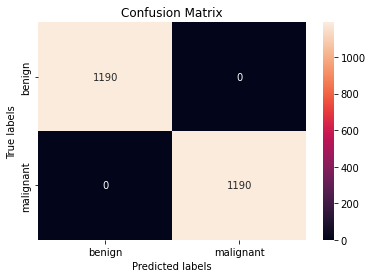

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_GANtrain).argmax(axis=1), np.asarray(y_GANtrain).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
# extract the predicted probabilities
p_pred_GANtest = MobileNetmodelv8forGAN.predict(X_GANtest)

In [ ]:
y_pred_GANtest = np.where(p_pred_GANtest > 0.5, 1, 0)
print(y_pred_GANtrain)

[[0 1]
 [0 1]
 [0 1]
 ...
 [0 1]
 [1 0]
 [1 0]]


In [ ]:
y_GANtest = to_categorical(y_GANtest, num_classes= 2)

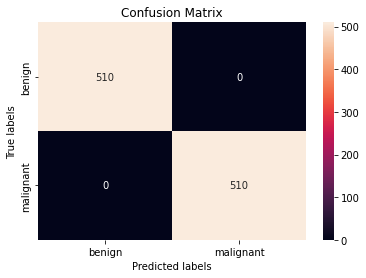

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_GANtest).argmax(axis=1), np.asarray(y_GANtest).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
GAN_Noncancer = np.load('/content/drive/My Drive/yazy/noncancer_lung_04Jun/output/generated_noncancer_nodules_2k_96x96.npy')
GAN_Cancer = np.load('/content/drive/MyDrive/yazy/cancer_lung_29May/output/generated_cancer_nodules_2k_96x96.npy')
print(GAN_Cancer.shape,GAN_Noncancer.shape,GAN_Cancer[0].shape,GAN_Noncancer[0].shape)

(2000, 96, 96, 3) (2000, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
testing_GAN_Cancer = GAN_Cancer[1700:]
testing_GAN_Noncancer = GAN_Noncancer[1700:]
print(testing_GAN_Cancer.shape,testing_GAN_Noncancer.shape,testing_GAN_Cancer[0].shape,testing_GAN_Noncancer[0].shape)

(300, 96, 96, 3) (300, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
X_GAN_testing = np.concatenate((testing_GAN_Cancer, testing_GAN_Noncancer), axis = 0)
Y_GAN_testing = np.concatenate((np.ones(300), np.zeros(300)), axis = 0)
print(X_GAN_testing.shape, Y_GAN_testing.shape)

(600, 96, 96, 3) (600,)


In [ ]:
# extract the predicted probabilities
p_predGAN_testing = MobileNetmodelv8forGAN.predict(X_GAN_testing)

In [ ]:
y_pred_GANtesting = np.where(p_predGAN_testing > 0.5, 1, 0)
print(y_pred_GANtesting)

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [ ]:
Y_GAN_testing = to_categorical(Y_GAN_testing, num_classes= 2)

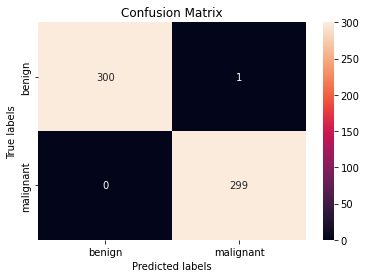

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_GANtesting).argmax(axis=1), np.asarray(Y_GAN_testing).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
from sklearn.metrics import roc_curve
p_GAN_train = MobileNetmodelv8forGAN.predict(X_GANtrain)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(np.asarray(y_GANtrain).argmax(axis=1), np.asarray(p_GAN_train).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
fpr_GANtrain = dict()
tpr_GANtrain = dict()
roc_GANtrainauc = dict()
for i in range(2):
    fpr_GANtrain[i], tpr_GANtrain[i], _ = roc_curve(y_GANtrain[:, i], p_GAN_train[:, i])
    roc_GANtrainauc[i] = auc(fpr_GANtrain[i], tpr_GANtrain[i])

# Compute micro-average ROC curve and ROC area
# fpr_GANtrain["micro"], tpr_GANtrain["micro"], _ = roc_curve(y_GANtrain.ravel(), p_GAN_train.ravel())
# roc_GANtrainauc["micro"] = auc(fpr_GANtrain["micro"], tpr_GANtrain["micro"])

In [ ]:
from sklearn.metrics import roc_curve
p_GAN_test = MobileNetmodelv8forGAN.predict(X_GANtest)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(np.asarray(y_GANtest).argmax(axis=1), np.asarray(p_GAN_test).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_rf = auc(fpr_rf, tpr_rf)

In [ ]:
fpr_GANtest = dict()
tpr_GANtest = dict()
roc_GANtestauc = dict()
for i in range(2):
    fpr_GANtest[i], tpr_GANtest[i], _ = roc_curve(y_GANtest[:, i], p_GAN_test[:, i])
    roc_GANtestauc[i] = auc(fpr_GANtest[i], tpr_GANtest[i])

# Compute micro-average ROC curve and ROC area
# fpr_GANtest["micro"], tpr_GANtest["micro"], _ = roc_curve(y_GANtest.ravel(), p_GAN_test.ravel())
# roc_GANtestauc["micro"] = auc(fpr_GANtest["micro"], tpr_GANtest["micro"])

In [ ]:
from sklearn.metrics import roc_curve
p_GAN_testing = MobileNetmodelv8forGAN.predict(X_GAN_testing)
fpr_rff, tpr_rff, thresholds_rf = roc_curve(np.asarray(Y_GAN_testing).argmax(axis=1), np.asarray(p_GAN_testing).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_rff = auc(fpr_rff, tpr_rff)

In [ ]:
fpr_GANtesting = dict()
tpr_GANtesting = dict()
roc_GANtestauc = dict()
for i in range(2):
    fpr_GANtesting[i], tpr_GANtesting[i], _ = roc_curve(Y_GAN_testing[:, i], p_GAN_testing[:, i])
    roc_GANtestauc[i] = auc(fpr_GANtesting[i], tpr_GANtesting[i])

# Compute micro-average ROC curve and ROC area
# fpr_GANtesting["micro"], tpr_GANtesting["micro"], _ = roc_curve(y_GANtest.ravel(), p_GAN_test.ravel())
# roc_GANtestauc["micro"] = auc(fpr_GANtesting["micro"], tpr_GANtesting["micro"])

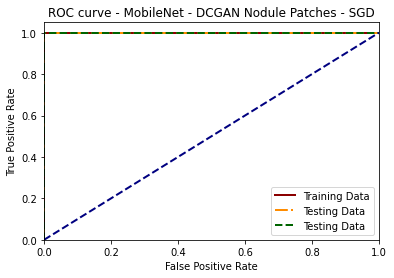

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr_GANtrain[1],
    tpr_GANtrain[1],
    color="darkred",
    lw=lw,
    label="Training Data" ,
)
plt.plot(
    fpr_GANtest[1],
    tpr_GANtest[1],
    color="darkorange",
    lw=lw,
    label="Testing Data",
    linestyle="dashdot",
)
plt.plot(
    fpr_GANtesting[1],
    tpr_GANtesting[1],
    color="darkgreen",
    lw=lw,
    label="Testing Data",
    linestyle="--",
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - MobileNet - DCGAN Nodule Patches - SGD")
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_GANtrain, axis=1), np.argmax(p_pred_GANtrain, axis=1)))

from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_GANtest, axis=1), np.argmax(p_GAN_test, axis=1)))

from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_GAN_testing, axis=1), np.argmax(p_GAN_testing, axis=1)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1190
           1       1.00      1.00      1.00      1190

    accuracy                           1.00      2380
   macro avg       1.00      1.00      1.00      2380
weighted avg       1.00      1.00      1.00      2380

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       510
           1       1.00      1.00      1.00       510

    accuracy                           1.00      1020
   macro avg       1.00      1.00      1.00      1020
weighted avg       1.00      1.00      1.00      1020

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [ ]:
y_pred_GANtesting = np.where(p_predGAN_testing > 0.5, 1, 0)
print(y_pred_GANtesting)

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [ ]:
Y_GAN_testing = to_categorical(Y_GAN_testing, num_classes= 2)

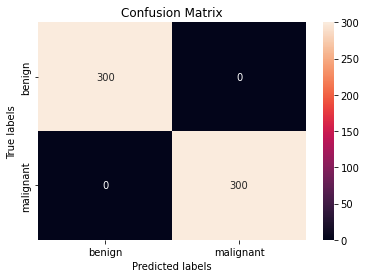

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_GANtesting).argmax(axis=1), np.asarray(Y_GAN_testing).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = MobileNetmodelv8_forGAN.predict(X_luna_train)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(np.asarray(y_luna_train).argmax(axis=1), np.asarray(y_pred_keras).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
from sklearn.metrics import roc_curve
y_test_keras = MobileNetmodelv8_forGAN.predict(X_luna_test)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(np.asarray(y_luna_test).argmax(axis=1), np.asarray(y_test_keras).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_rf = auc(fpr_rf, tpr_rf)

In [ ]:
from sklearn.metrics import roc_curve
y_pred_s = MobileNetmodelv8_forGAN.predict(X_lunas)
fpr_rff, tpr_rff, thresholds_rf = roc_curve(np.asarray(Y_lunas).argmax(axis=1), np.asarray(y_pred_s).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_rff = auc(fpr_rff, tpr_rff)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_luna_train, axis=1), np.argmax(y_pred_train, axis=1)))

              precision    recall  f1-score   support

           0       0.55      0.94      0.69       595
           1       0.79      0.23      0.35       595

    accuracy                           0.58      1190
   macro avg       0.67      0.58      0.52      1190
weighted avg       0.67      0.58      0.52      1190



In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_luna_test, axis=1), np.argmax(p_pred_test, axis=1)))

              precision    recall  f1-score   support

           0       0.57      0.86      0.68       255
           1       0.71      0.35      0.47       255

    accuracy                           0.60       510
   macro avg       0.64      0.60      0.58       510
weighted avg       0.64      0.60      0.58       510



In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_lunas, axis=1), np.argmax(y_pred_s, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.50      1.00      0.67        50

    accuracy                           0.50       100
   macro avg       0.25      0.50      0.33       100
weighted avg       0.25      0.50      0.33       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


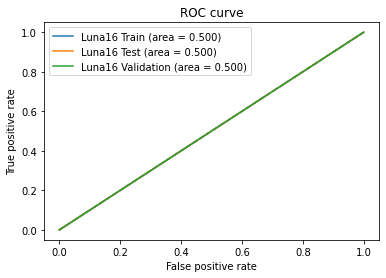

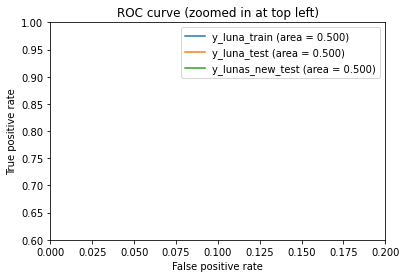

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Luna16 Train (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='Luna16 Test (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_rff, tpr_rff, label='Luna16 Validation (area = {:.3f})'.format(auc_rff))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0,0.2)
plt.ylim(0.6,1.0)
plt.plot([0, 2], [0, 2], 'k--')
plt.plot(fpr_keras, tpr_keras, label='y_luna_train (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='y_luna_test (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_rff, tpr_rff, label='y_lunas_new_test (area = {:.3f})'.format(auc_rff))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
from tensorflow.keras.layers import Input, DepthwiseConv2D, \
     Conv2D, BatchNormalization, ReLU, AvgPool2D, Flatten, Dense

def mobilenet_block(x, filters, strides):
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

INPUT_SHAPE = 96, 96, 3

input = Input(INPUT_SHAPE)
x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)

x = mobilenet_block(x, filters=64, strides=1)

x = mobilenet_block(x, filters=128, strides=2)
x = mobilenet_block(x, filters=128, strides=1)

x = mobilenet_block(x, filters=256, strides=2)
x = mobilenet_block(x, filters=256, strides=1)

x = mobilenet_block(x, filters=512, strides=2)
for _ in range(5):
    x = mobilenet_block(x, filters=512, strides=1)
  
x = mobilenet_block(x, filters=1024, strides=2)
x = mobilenet_block(x, filters=1024, strides=1)

x = AvgPool2D(pool_size=7, strides=1)(x)
output = Dense(units=1000, activation='softmax')(x)

from tensorflow.keras import Model

model = Model(inputs=input, outputs=output)

In [ ]:
from tensorflow.keras.layers import Input, DepthwiseConv2D, \
     Conv2D, BatchNormalization, ReLU, AvgPool2D, Flatten, Dense

def mobilenet_block(x, filters, strides):
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

INPUT_SHAPE = 96, 96, 3

input = Input(INPUT_SHAPE)
x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)

x = mobilenet_block(x, filters=64, strides=1)

x = mobilenet_block(x, filters=128, strides=2)
# x = mobilenet_block(x, filters=128, strides=1)

# x = mobilenet_block(x, filters=256, strides=2)
# x = mobilenet_block(x, filters=256, strides=1)

# x = mobilenet_block(x, filters=512, strides=2)
# for _ in range(1):
#     x = mobilenet_block(x, filters=512, strides=1)
  
# x = mobilenet_block(x, filters=1024, strides=2)
# x = mobilenet_block(x, filters=1024, strides=1)

x = AvgPool2D(pool_size=7, strides=1)(x)
x = Flatten()(x)
output = Dense(units=2, activation='sigmoid')(x)

from tensorflow.keras import Model

MobileNetmodelv2 = Model(inputs=input, outputs=output)

In [ ]:
MobileNetmodelv2.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_68 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_126 (Ba  (None, 48, 48, 32)       128       
 tchNormalization)                                               
                                                                 
 re_lu_126 (ReLU)            (None, 48, 48, 32)        0         
                                                                 
 depthwise_conv2d_58 (Depthw  (None, 48, 48, 32)       320       
 iseConv2D)                                                      
                                                                 
 batch_normalization_127 (Ba  (None, 48, 48, 32)       128 

In [ ]:
MobileNetmodel.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_51 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_96 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 re_lu_96 (ReLU)             (None, 48, 48, 32)        0         
                                                                 
 depthwise_conv2d_45 (Depthw  (None, 48, 48, 32)       320       
 iseConv2D)                                                      
                                                                 
 batch_normalization_97 (Bat  (None, 48, 48, 32)       128 

In [ ]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


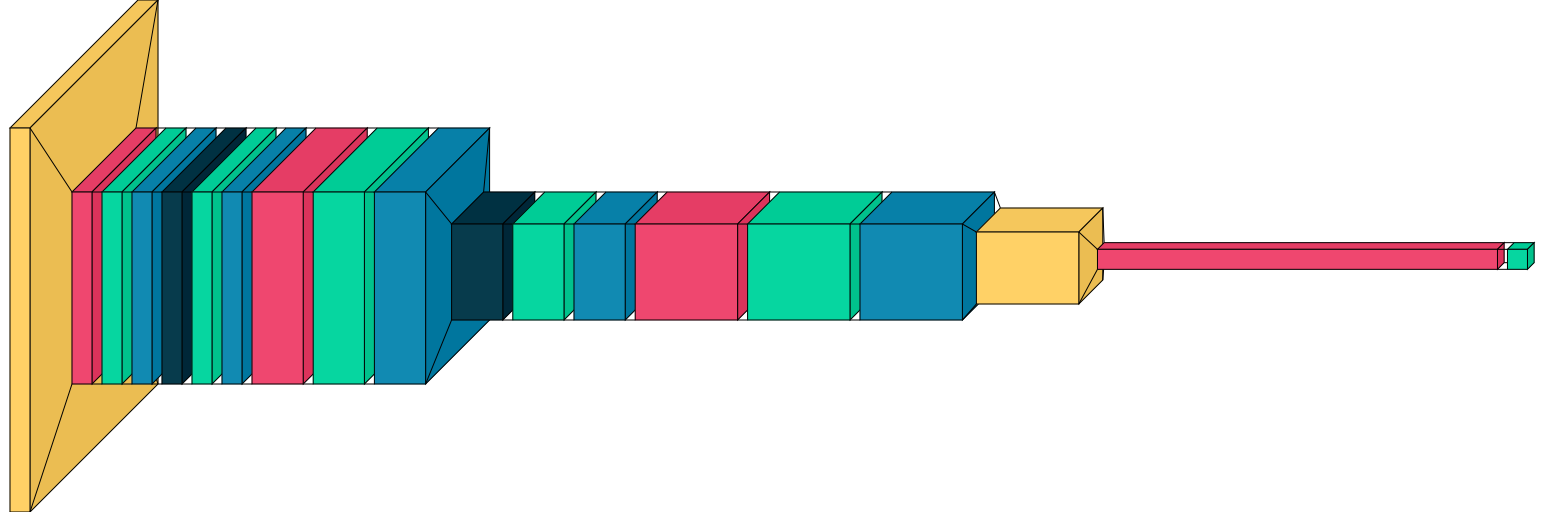

In [ ]:
import visualkeras
visualkeras.layered_view(MobileNetmodel)

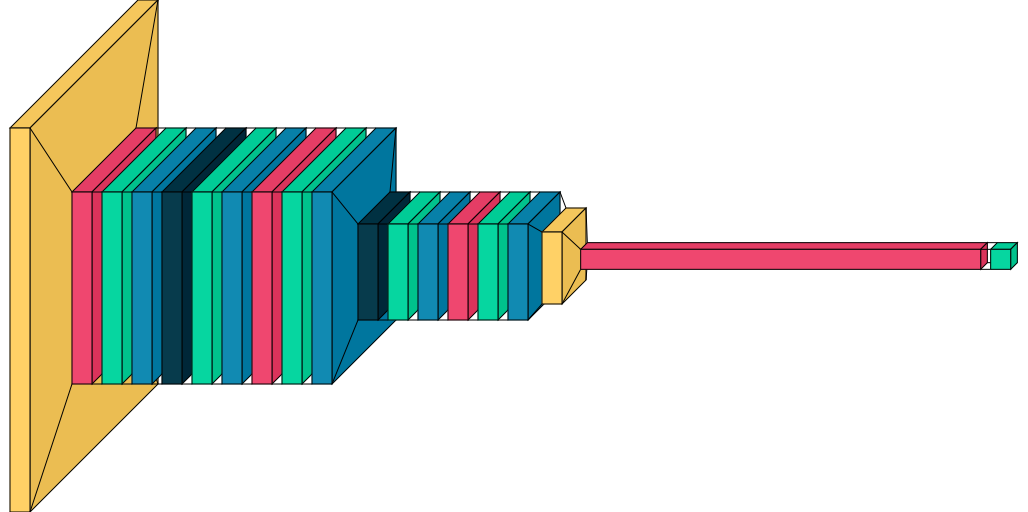

In [ ]:
import visualkeras
visualkeras.layered_view(MobileNetmodelv2)

In [ ]:
def build_model(lr=1e-4):
   return tf.keras.models.Sequential([
      # 1st conv
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(96, 96, 3)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
      # 2nd conv
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(46, 46, 3)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
      # 3rd conv
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', input_shape=(23, 23, 3)),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
    
    # To Flatten layer
    tf.keras.layers.Flatten(),
    # To FC layer 1
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='sigmoid')
  ])

In [ ]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='categorical_crossentropy',#loss='binary_crossentropy', #
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
# K.clear_session()
# gc.collect()

# resnet = tf.keras.applications.InceptionV3(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(96,96,3)
# )


 
#building Alexnet - v1 Model

Alexnet_model = build_model(lr = 1e-6)
Alexnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 94, 94, 64)        1792      
                                                                 
 conv2d_48 (Conv2D)          (None, 92, 92, 64)        36928     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 44, 44, 128)       73856     
                                                                 
 conv2d_50 (Conv2D)          (None, 42, 42, 128)       147584    
                                                                 
 conv2d_51 (Conv2D)          (None, 40, 40, 128)       147584    
                                                      

In [ ]:
def train_model_mobilenet():
  
  # model = create_model()
  MobileNetmodelv2.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "MobileNetmodel",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  MobileNetmodelv2.fit(x=X_luna_train, 
            y=y_luna_train, 
            epochs=20, 
            validation_data=(X_luna_test, y_luna_test), 
            callbacks=[tensorboard_callback])

train_model_mobilenet()

Epoch 1/20
38/38 [==============================] - 2s 35ms/step - loss: 4.2168 - accuracy: 0.5714 - val_loss: 0.8194 - val_accuracy: 0.5000
Epoch 2/20
38/38 [==============================] - 1s 28ms/step - loss: 1.3351 - accuracy: 0.6958 - val_loss: 1.8869 - val_accuracy: 0.5000
Epoch 3/20
38/38 [==============================] - 1s 28ms/step - loss: 0.8394 - accuracy: 0.7218 - val_loss: 2.3810 - val_accuracy: 0.5000
Epoch 4/20
38/38 [==============================] - 1s 28ms/step - loss: 0.7131 - accuracy: 0.7605 - val_loss: 3.9250 - val_accuracy: 0.5000
Epoch 5/20
38/38 [==============================] - 1s 28ms/step - loss: 0.7216 - accuracy: 0.7748 - val_loss: 1.0865 - val_accuracy: 0.5000
Epoch 6/20
38/38 [==============================] - 1s 28ms/step - loss: 0.5639 - accuracy: 0.7882 - val_loss: 1.8619 - val_accuracy: 0.5000
Epoch 7/20
38/38 [==============================] - 1s 28ms/step - loss: 0.3483 - accuracy: 0.8538 - val_loss: 1.7989 - val_accuracy: 0.5000
Epoch 8/20
38

In [ ]:
def train_model_mobilenet():
  
  # model = create_model()
  MobileNetmodel.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "MobileNetmodel",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  MobileNetmodel.fit(x=X_luna_train, 
            y=y_luna_train, 
            epochs=20, 
            validation_data=(X_luna_test, y_luna_test), 
            callbacks=[tensorboard_callback])

train_model_mobilenet()

Epoch 1/20
38/38 [==============================] - 6s 90ms/step - loss: 25.6664 - accuracy: 0.5412 - val_loss: 1.0936 - val_accuracy: 0.5000
Epoch 2/20
38/38 [==============================] - 3s 70ms/step - loss: 6.4453 - accuracy: 0.6395 - val_loss: 0.9130 - val_accuracy: 0.5000
Epoch 3/20
38/38 [==============================] - 3s 71ms/step - loss: 4.9300 - accuracy: 0.6613 - val_loss: 4.2204 - val_accuracy: 0.5000
Epoch 4/20
38/38 [==============================] - 3s 69ms/step - loss: 4.3350 - accuracy: 0.6655 - val_loss: 2.4862 - val_accuracy: 0.5000
Epoch 5/20
38/38 [==============================] - 3s 70ms/step - loss: 5.3172 - accuracy: 0.6395 - val_loss: 4.9778 - val_accuracy: 0.5000
Epoch 6/20
38/38 [==============================] - 3s 69ms/step - loss: 3.0878 - accuracy: 0.7168 - val_loss: 0.7140 - val_accuracy: 0.5451
Epoch 7/20
38/38 [==============================] - 3s 69ms/step - loss: 2.6089 - accuracy: 0.7378 - val_loss: 1.9964 - val_accuracy: 0.5000
Epoch 8/20
3

In [ ]:
def train_model_mobilenet():
  
  # model = create_model()
  MobileNetmodel.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "MobileNetmodel",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  MobileNetmodel.fit(x=X_luna_train, 
            y=y_luna_train, 
            epochs=20, 
            validation_data=(X_luna_test, y_luna_test), 
            callbacks=[tensorboard_callback])

train_model_mobilenet()

Epoch 1/20
38/38 [==============================] - 12s 295ms/step - loss: 0.6929 - accuracy: 0.5084 - val_loss: 0.6920 - val_accuracy: 0.5020
Epoch 2/20
38/38 [==============================] - 13s 348ms/step - loss: 0.6916 - accuracy: 0.5756 - val_loss: 0.6907 - val_accuracy: 0.5471
Epoch 3/20
38/38 [==============================] - 13s 358ms/step - loss: 0.6902 - accuracy: 0.6160 - val_loss: 0.6890 - val_accuracy: 0.5137
Epoch 4/20
38/38 [==============================] - 12s 321ms/step - loss: 0.6880 - accuracy: 0.5992 - val_loss: 0.6866 - val_accuracy: 0.6157
Epoch 5/20
38/38 [==============================] - 11s 308ms/step - loss: 0.6851 - accuracy: 0.6034 - val_loss: 0.6834 - val_accuracy: 0.6706
Epoch 6/20
38/38 [==============================] - 11s 297ms/step - loss: 0.6799 - accuracy: 0.6857 - val_loss: 0.6781 - val_accuracy: 0.6059
Epoch 7/20
38/38 [==============================] - 11s 301ms/step - loss: 0.6729 - accuracy: 0.6588 - val_loss: 0.6720 - val_accuracy: 0.6549

In [ ]:
# extract the predicted probabilities
p_pred_train = MobileNetmodel.predict(X_luna_train)

In [ ]:
y_pred_train = np.where(p_pred_train > 0.5, 1, 0)
print(y_pred_train)

[[1 0]
 [0 1]
 [0 1]
 ...
 [0 1]
 [0 1]
 [0 1]]


In [ ]:
y_luna_train = to_categorical(y_luna_train, num_classes= 2)

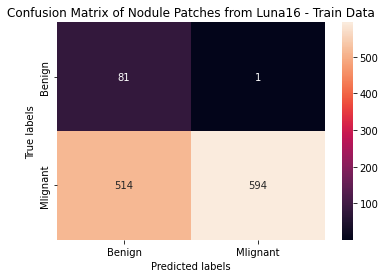

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['Benign','Mlignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_train).argmax(axis=1), np.asarray(y_luna_train).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Nodule Patches from Luna16 - Train Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
# extract the predicted probabilities
p_pred_train = MobileNetmodelv2.predict(X_luna_train)

In [ ]:
y_pred_train = np.where(p_pred_train > 0.5, 1, 0)
print(y_pred_train)

[[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [ ]:
y_luna_train = to_categorical(y_luna_train, num_classes= 2)

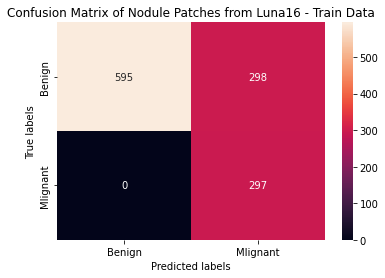

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['Benign','Mlignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_train).argmax(axis=1), np.asarray(y_luna_train).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Nodule Patches from Luna16 - Train Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
# extract the predicted probabilities
p_pred_test = MobileNetmodel.predict(X_luna_test)

In [ ]:
y_pred_test = np.where(p_pred_test > 0.5, 1, 0)
print(y_pred_test)

[[0 1]
 [0 1]
 [0 1]
 ...
 [0 1]
 [0 1]
 [0 1]]


In [ ]:
y_luna_test = to_categorical(y_luna_test, num_classes= 2)

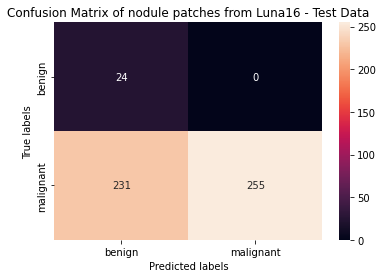

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_test).argmax(axis=1), np.asarray(y_luna_test).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of nodule patches from Luna16 - Test Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
# extract the predicted probabilities
p_pred_test = MobileNetmodelv2.predict(X_luna_test)

In [ ]:
y_pred_test = np.where(p_pred_test > 0.5, 1, 0)
print(y_pred_test)

[[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [0 1]
 [1 0]]


In [ ]:
y_luna_test = to_categorical(y_luna_test, num_classes= 2)

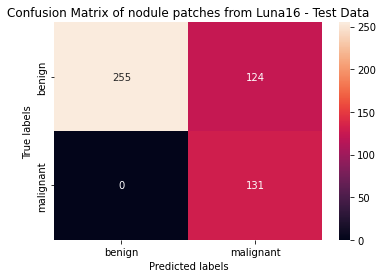

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_test).argmax(axis=1), np.asarray(y_luna_test).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of nodule patches from Luna16 - Test Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
!tensorboard dev upload --logdir logs


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=rLWXHprSh8EcM1xTLyPSnAU7sOco1U&prompt=consent&access_type=offline
Enter th

In [ ]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 5.1 MB/s 


In [ ]:
luna_cancer_data = np.load('/content/drive/MyDrive/Ramasubramanya/LotusFeet/cancernodule_image_900_96_96_patches.npy')
testing_luna_cancer_data = luna_cancer_data[850:]
print(testing_luna_cancer_data.shape, testing_luna_cancer_data[0].shape)

(50, 96, 96, 1) (96, 96, 1)


In [ ]:
testing_luna_cancer_data = testing_luna_cancer_data.reshape(50,96,96)
testing_luna_cancer_data_rgb = np.repeat(testing_luna_cancer_data[..., np.newaxis], 3, -1)
print(testing_luna_cancer_data_rgb.shape, testing_luna_cancer_data_rgb[0].shape)

(50, 96, 96, 3) (96, 96, 3)


In [ ]:
luna_non_cancer_data = np.load("/content/drive/MyDrive/Ramasubramanya/LotusFeet/non_cancernodule_image_1400_96_96_patches.npy")
testing_luna_non_cancer_data = luna_non_cancer_data[850:900]
print(testing_luna_non_cancer_data.shape, testing_luna_non_cancer_data[0].shape)

(50, 96, 96, 1) (96, 96, 1)


In [ ]:
testing_luna_non_cancer_data = testing_luna_non_cancer_data.reshape(50,96,96)
testing_luna_non_cancer_data_rgb = np.repeat(testing_luna_non_cancer_data[..., np.newaxis], 3, -1)
print(testing_luna_non_cancer_data_rgb.shape, testing_luna_non_cancer_data_rgb[0].shape)

(50, 96, 96, 3) (96, 96, 3)


In [ ]:
X_lunas = np.concatenate((testing_luna_cancer_data_rgb,testing_luna_non_cancer_data_rgb), axis = 0)
print(X_lunas.shape, X_lunas[0].shape)

(100, 96, 96, 3) (96, 96, 3)


In [ ]:
testing_cancer_labels = np.ones(50)
testing_noncancer_labels = np.zeros(50)
Y_lunas = np.concatenate((testing_cancer_labels,testing_noncancer_labels), axis = 0)

In [ ]:
# extract the predicted probabilities
p_pred_tests = MobileNetmodel.predict(X_lunas)

In [ ]:
y_pred_tests = np.where(p_pred_tests > 0.5, 1, 0)
print(y_pred_tests)

[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]]


In [ ]:
Y_lunas = to_categorical(Y_lunas, num_classes= 2)

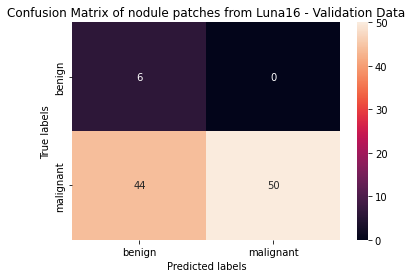

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_tests).argmax(axis=1), np.asarray(Y_lunas).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of nodule patches from Luna16 - Validation Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
# extract the predicted probabilities
p_pred_tests = MobileNetmodelv2.predict(X_lunas)

In [ ]:
y_pred_tests = np.where(p_pred_tests > 0.5, 1, 0)
print(y_pred_tests)

[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]


In [ ]:
Y_lunas = to_categorical(Y_lunas, num_classes= 2)

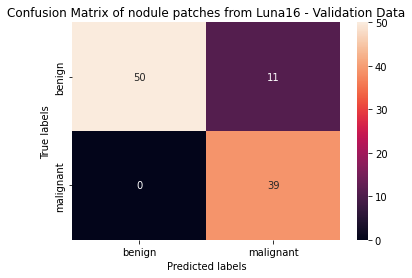

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_tests).argmax(axis=1), np.asarray(Y_lunas).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of nodule patches from Luna16 - Validation Data'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = MobileNetmodel.predict(X_luna_train)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(np.asarray(y_luna_train).argmax(axis=1), np.asarray(y_pred_keras).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
from sklearn.metrics import roc_curve
y_test_keras = MobileNetmodel.predict(X_luna_test)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(np.asarray(y_luna_test).argmax(axis=1), np.asarray(y_test_keras).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_rf = auc(fpr_rf, tpr_rf)

In [ ]:
from sklearn.metrics import roc_curve
y_pred_s = MobileNetmodel.predict(X_lunas)
fpr_rff, tpr_rff, thresholds_rf = roc_curve(np.asarray(Y_lunas).argmax(axis=1), np.asarray(y_pred_s).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_rff = auc(fpr_rff, tpr_rff)

In [ ]:
print(auc_rf)

0.7235294117647059


In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_luna_train, axis=1), np.argmax(y_pred_train, axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.14      0.24       595
           1       0.54      1.00      0.70       595

    accuracy                           0.57      1190
   macro avg       0.76      0.57      0.47      1190
weighted avg       0.76      0.57      0.47      1190



In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(y_luna_test, axis=1), np.argmax(p_pred_test, axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.09      0.17       255
           1       0.52      1.00      0.69       255

    accuracy                           0.55       510
   macro avg       0.76      0.55      0.43       510
weighted avg       0.76      0.55      0.43       510



In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_lunas, axis=1), np.argmax(y_pred_s, axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.12      0.21        50
           1       0.53      1.00      0.69        50

    accuracy                           0.56       100
   macro avg       0.77      0.56      0.45       100
weighted avg       0.77      0.56      0.45       100



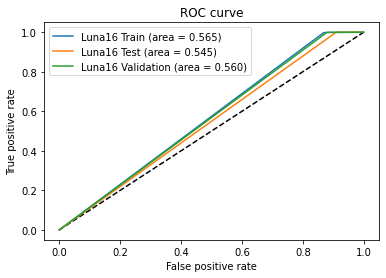

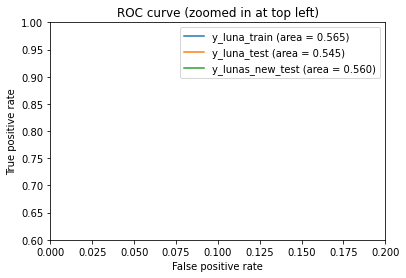

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Luna16 Train (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='Luna16 Test (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_rff, tpr_rff, label='Luna16 Validation (area = {:.3f})'.format(auc_rff))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0,0.2)
plt.ylim(0.6,1.0)
plt.plot([0, 2], [0, 2], 'k--')
plt.plot(fpr_keras, tpr_keras, label='y_luna_train (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='y_luna_test (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_rff, tpr_rff, label='y_lunas_new_test (area = {:.3f})'.format(auc_rff))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
GAN_Noncancer = np.load('/content/drive/My Drive/yazy/noncancer_lung_04Jun/output/generated_noncancer_nodules_2k_96x96.npy')
GAN_Cancer = np.load('/content/drive/MyDrive/yazy/cancer_lung_29May/output/generated_cancer_nodules_2k_96x96.npy')
print(GAN_Cancer.shape,GAN_Noncancer.shape,GAN_Cancer[0].shape,GAN_Noncancer[0].shape)

(2000, 96, 96, 3) (2000, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
GAN_Cancer = GAN_Cancer[:1700]
GAN_Noncancer = GAN_Noncancer[:1700]
print(GAN_Cancer.shape,GAN_Noncancer.shape,GAN_Cancer[0].shape,GAN_Noncancer[0].shape)

(1700, 96, 96, 3) (1700, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
X_GAN = np.concatenate((GAN_Cancer, GAN_Noncancer), axis = 0)
Y_GAN = np.concatenate((np.ones(1700), np.zeros(1700)), axis = 0)
print(X_GAN.shape, Y_GAN.shape)

(3400, 96, 96, 3) (3400,)


In [ ]:
from sklearn.model_selection import train_test_split
(X_GANtrain, X_GANtest, y_GANtrain, y_GANtest) = train_test_split(X_GAN, Y_GAN,test_size=0.3, stratify=Y_GAN, random_state=42)

In [ ]:
print(X_GANtrain.shape, X_GANtest.shape, y_GANtrain.shape, y_GANtest.shape)

(2380, 96, 96, 3) (1020, 96, 96, 3) (2380,) (1020,)


In [ ]:
from tensorflow.keras.layers import Input, DepthwiseConv2D, \
     Conv2D, BatchNormalization, ReLU, AvgPool2D, Flatten, Dense

def mobilenet_block(x, filters, strides):
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

INPUT_SHAPE = 96, 96, 3

input = Input(INPUT_SHAPE)
x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)

x = mobilenet_block(x, filters=64, strides=1)

x = mobilenet_block(x, filters=128, strides=2)
x = mobilenet_block(x, filters=128, strides=1)

x = mobilenet_block(x, filters=256, strides=2)
x = mobilenet_block(x, filters=256, strides=1)

x = mobilenet_block(x, filters=512, strides=2)
for _ in range(5):
    x = mobilenet_block(x, filters=512, strides=1)
  
x = mobilenet_block(x, filters=1024, strides=2)
x = mobilenet_block(x, filters=1024, strides=1)

# x = AvgPool2D(pool_size=7, strides=1)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = Dense(units=2, activation='sigmoid')(x)

from tensorflow.keras import Model

MobileNetmodelv8_GAN = Model(inputs=input, outputs=output)

In [ ]:
MobileNetmodelv8_GAN.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_67 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_120 (Ba  (None, 48, 48, 32)       128       
 tchNormalization)                                               
                                                                 
 re_lu_120 (ReLU)            (None, 48, 48, 32)        0         
                                                                 
 depthwise_conv2d_53 (Depthw  (None, 48, 48, 32)       320       
 iseConv2D)                                                      
                                                                 
 batch_normalization_121 (Ba  (None, 48, 48, 32)       128 

In [ ]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 4.2 MB/s 


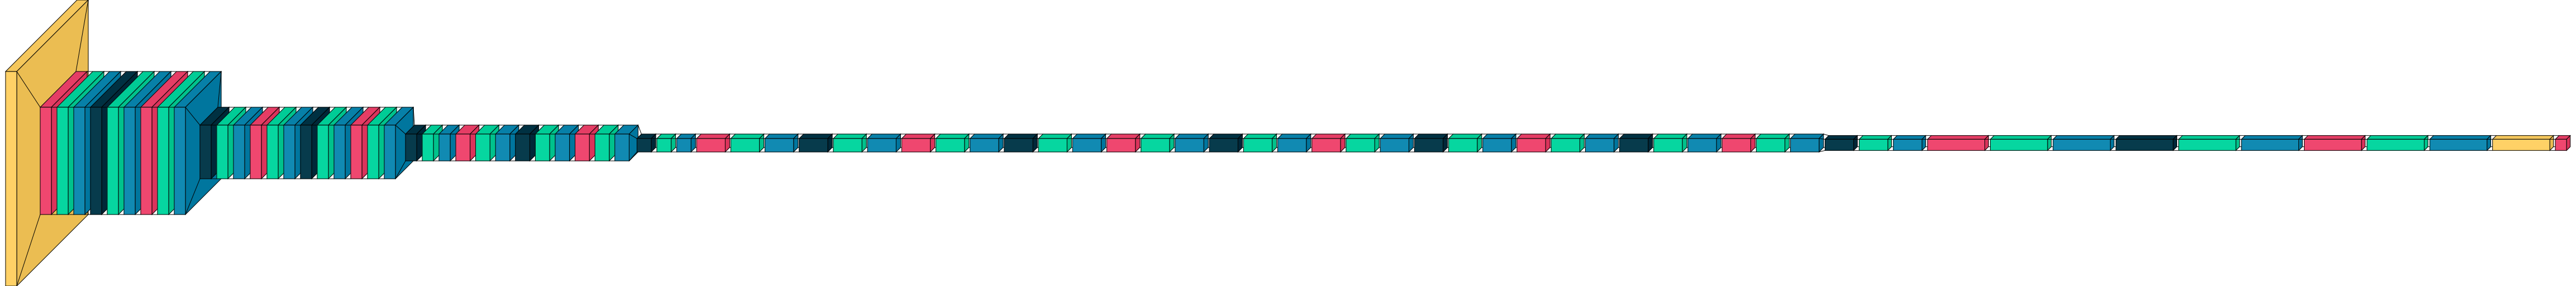

In [ ]:
import visualkeras
visualkeras.layered_view(MobileNetmodelv8_GAN)

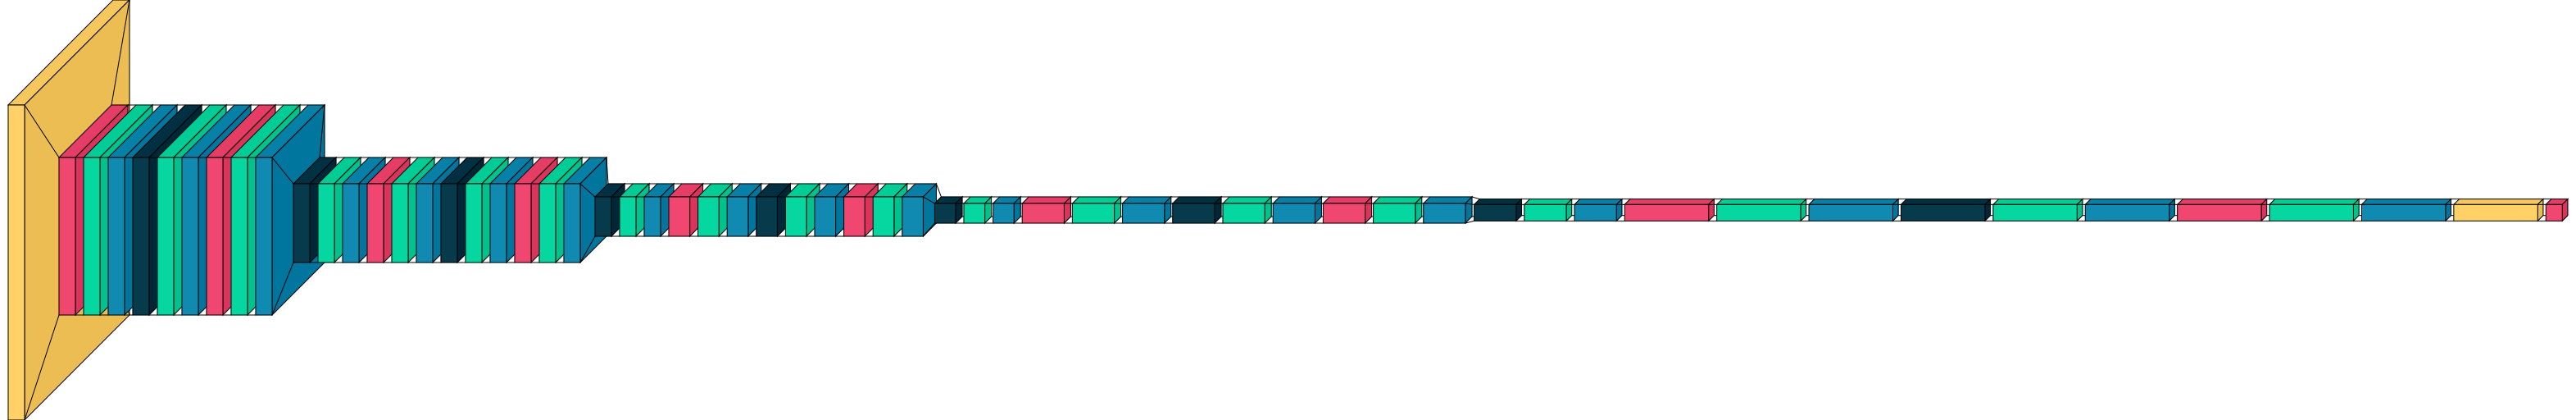

In [ ]:
import visualkeras
visualkeras.layered_view(MobileNetmodelv7_GAN)

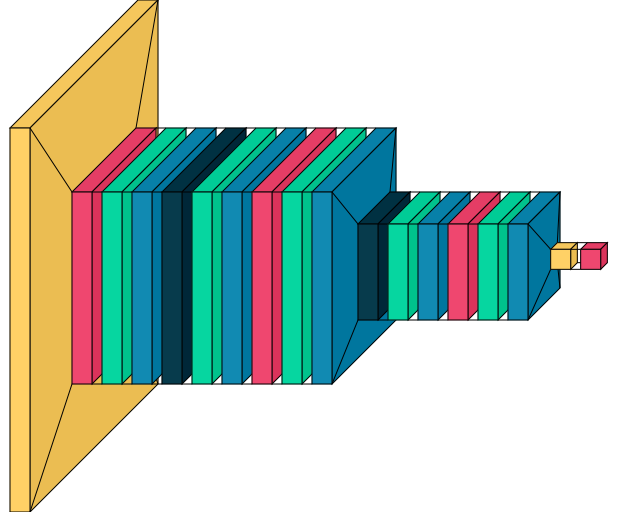

In [ ]:
import visualkeras
visualkeras.layered_view(MobileNetmodelv6_GAN)

In [ ]:
def train_model_mobilenet():
  
  # model = create_model()
  MobileNetmodelv8_GAN.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "MobileNetmodel",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  MobileNetmodelv8_GAN.fit(x=X_luna_train, 
            y=y_luna_train, 
            epochs=20, 
            validation_data=(X_luna_test, y_luna_test), 
            callbacks=[tensorboard_callback])

train_model_mobilenet()

Epoch 1/20
38/38 [==============================] - 5s 72ms/step - loss: 0.6887 - accuracy: 0.5824 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/20
38/38 [==============================] - 2s 57ms/step - loss: 0.6147 - accuracy: 0.6471 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 3/20
38/38 [==============================] - 2s 57ms/step - loss: 0.5401 - accuracy: 0.7134 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/20
38/38 [==============================] - 2s 57ms/step - loss: 0.4823 - accuracy: 0.7723 - val_loss: 0.7002 - val_accuracy: 0.5000
Epoch 5/20
38/38 [==============================] - 2s 56ms/step - loss: 0.4469 - accuracy: 0.7891 - val_loss: 0.7021 - val_accuracy: 0.5000
Epoch 6/20
38/38 [==============================] - 2s 56ms/step - loss: 0.4237 - accuracy: 0.8084 - val_loss: 0.7516 - val_accuracy: 0.5000
Epoch 7/20
38/38 [==============================] - 2s 58ms/step - loss: 0.3932 - accuracy: 0.8160 - val_loss: 0.7020 - val_accuracy: 0.5000
Epoch 8/20
38

In [ ]:
def train_model_mobilenet():
  
  # model = create_model()
  MobileNetmodelv7_GAN.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "MobileNetmodel",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  MobileNetmodelv7_GAN.fit(x=X_luna_train, 
            y=y_luna_train, 
            epochs=20, 
            validation_data=(X_luna_test, y_luna_test), 
            callbacks=[tensorboard_callback])

train_model_mobilenet()

Epoch 1/20
38/38 [==============================] - 4s 66ms/step - loss: 0.6290 - accuracy: 0.6319 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 2/20
38/38 [==============================] - 2s 46ms/step - loss: 0.4779 - accuracy: 0.7672 - val_loss: 0.6962 - val_accuracy: 0.5000
Epoch 3/20
38/38 [==============================] - 2s 45ms/step - loss: 0.4268 - accuracy: 0.8059 - val_loss: 0.7026 - val_accuracy: 0.5000
Epoch 4/20
38/38 [==============================] - 2s 46ms/step - loss: 0.3938 - accuracy: 0.8286 - val_loss: 0.7293 - val_accuracy: 0.5000
Epoch 5/20
38/38 [==============================] - 2s 47ms/step - loss: 0.3084 - accuracy: 0.8840 - val_loss: 0.7419 - val_accuracy: 0.5000
Epoch 6/20
38/38 [==============================] - 2s 46ms/step - loss: 0.3120 - accuracy: 0.8689 - val_loss: 0.8489 - val_accuracy: 0.5000
Epoch 7/20
38/38 [==============================] - 2s 46ms/step - loss: 0.2731 - accuracy: 0.8849 - val_loss: 0.8205 - val_accuracy: 0.5000
Epoch 8/20
38

In [ ]:
from tensorflow.keras.layers import Input, DepthwiseConv2D, \
     Conv2D, BatchNormalization, ReLU, AvgPool2D, Flatten, Dense

def mobilenet_block(x, filters, strides):
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

INPUT_SHAPE = 96, 96, 3

input = Input(INPUT_SHAPE)
x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)

x = mobilenet_block(x, filters=64, strides=1)

x = mobilenet_block(x, filters=128, strides=2)
# x = mobilenet_block(x, filters=128, strides=1)

# x = mobilenet_block(x, filters=256, strides=2)
# x = mobilenet_block(x, filters=256, strides=1)

# x = mobilenet_block(x, filters=512, strides=2)
# for _ in range(1):
#     x = mobilenet_block(x, filters=512, strides=1)
  
# x = mobilenet_block(x, filters=1024, strides=2)
# x = mobilenet_block(x, filters=1024, strides=1)

x = AvgPool2D(pool_size=7, strides=1)(x)
x = Flatten()(x)
output = Dense(units=2, activation='sigmoid')(x)

from tensorflow.keras import Model

MobileNetmodelv3_GAN = Model(inputs=input, outputs=output)

In [ ]:
MobileNetmodelv3_GAN.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_77 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_141 (Ba  (None, 48, 48, 32)       128       
 tchNormalization)                                               
                                                                 
 re_lu_141 (ReLU)            (None, 48, 48, 32)        0         
                                                                 
 depthwise_conv2d_64 (Depthw  (None, 48, 48, 32)       320       
 iseConv2D)                                                      
                                                                 
 batch_normalization_142 (Ba  (None, 48, 48, 32)       128

In [ ]:
from tensorflow.keras.layers import Input, DepthwiseConv2D, \
     Conv2D, BatchNormalization, ReLU, AvgPool2D, Flatten, Dense

def mobilenet_block(x, filters, strides):
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

INPUT_SHAPE = 96, 96, 3

input = Input(INPUT_SHAPE)
x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)

x = mobilenet_block(x, filters=64, strides=1)

x = mobilenet_block(x, filters=128, strides=2)
x = mobilenet_block(x, filters=128, strides=1)

x = mobilenet_block(x, filters=256, strides=2)
x = mobilenet_block(x, filters=256, strides=1)

# x = mobilenet_block(x, filters=512, strides=2)
# for _ in range(1):
#     x = mobilenet_block(x, filters=512, strides=1)
  
# x = mobilenet_block(x, filters=1024, strides=2)
# x = mobilenet_block(x, filters=1024, strides=1)

x = AvgPool2D(pool_size=7, strides=1)(x)
x = Flatten()(x)
output = Dense(units=2, activation='sigmoid')(x)

from tensorflow.keras import Model

MobileNetmodelv4_GAN = Model(inputs=input, outputs=output)

In [ ]:
MobileNetmodelv4_GAN.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_101 (Conv2D)         (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_186 (Ba  (None, 48, 48, 32)       128       
 tchNormalization)                                               
                                                                 
 re_lu_186 (ReLU)            (None, 48, 48, 32)        0         
                                                                 
 depthwise_conv2d_85 (Depthw  (None, 48, 48, 32)       320       
 iseConv2D)                                                      
                                                                 
 batch_normalization_187 (Ba  (None, 48, 48, 32)       128

In [ ]:
from tensorflow.keras.layers import Input, DepthwiseConv2D, \
     Conv2D, BatchNormalization, ReLU, AvgPool2D, Flatten, Dense

def mobilenet_block(x, filters, strides):
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

INPUT_SHAPE = 96, 96, 3

input = Input(INPUT_SHAPE)
x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)

x = mobilenet_block(x, filters=64, strides=1)

x = mobilenet_block(x, filters=128, strides=2)
x = mobilenet_block(x, filters=128, strides=1)

x = mobilenet_block(x, filters=256, strides=2)
x = mobilenet_block(x, filters=256, strides=1)

# x = mobilenet_block(x, filters=512, strides=2)
# for _ in range(1):
#     x = mobilenet_block(x, filters=512, strides=1)
  
# x = mobilenet_block(x, filters=1024, strides=2)
# x = mobilenet_block(x, filters=1024, strides=1)

x = AvgPool2D(pool_size=7, strides=1)(x)
# x = Flatten()(x)
output = Dense(units=1, activation='sigmoid')(x)
x = Flatten()(x)
from tensorflow.keras import Model

MobileNetmodelv5_GAN = Model(inputs=input, outputs=output)

In [ ]:
MobileNetmodelv5_GAN.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_209 (Conv2D)         (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_388 (Ba  (None, 48, 48, 32)       128       
 tchNormalization)                                               
                                                                 
 re_lu_388 (ReLU)            (None, 48, 48, 32)        0         
                                                                 
 depthwise_conv2d_179 (Depth  (None, 48, 48, 32)       320       
 wiseConv2D)                                                     
                                                                 
 batch_normalization_389 (Ba  (None, 48, 48, 32)       128

In [ ]:
from tensorflow.keras.layers import Input, DepthwiseConv2D, \
     Conv2D, BatchNormalization, ReLU, AvgPool2D, Flatten, Dense

def mobilenet_block(x, filters, strides):
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

INPUT_SHAPE = 96, 96, 3

input = Input(INPUT_SHAPE)
x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)

x = mobilenet_block(x, filters=64, strides=1)

# x = mobilenet_block(x, filters=128, strides=2)
# x = mobilenet_block(x, filters=128, strides=1)

# x = mobilenet_block(x, filters=256, strides=2)
# x = mobilenet_block(x, filters=256, strides=1)

# x = mobilenet_block(x, filters=512, strides=2)
for _ in range(5):
    x = mobilenet_block(x, filters=512, strides=1)
  
x = mobilenet_block(x, filters=1024, strides=2)
# x = mobilenet_block(x, filters=1024, strides=1)

x = AvgPool2D(pool_size=7, strides=1)(x)
output = Dense(units=1000, activation='softmax')(x)

from tensorflow.keras import Model

MobileNetmodel_v1 = Model(inputs=input, outputs=output)

In [ ]:
MobileNetmodel_v1.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_91 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 batch_normalization_167 (Ba  (None, 48, 48, 32)       128       
 tchNormalization)                                               
                                                                 
 re_lu_167 (ReLU)            (None, 48, 48, 32)        0         
                                                                 
 depthwise_conv2d_76 (Depthw  (None, 48, 48, 32)       320       
 iseConv2D)                                                      
                                                                 
 batch_normalization_168 (Ba  (None, 48, 48, 32)       128

In [ ]:
def train_model_mobilenet():
  
  # model = create_model()
  MobileNetmodelv3_GAN.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "MobileNetmodel_v1",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  MobileNetmodelv3_GAN.fit(x=X_GANtrain, 
            y=y_GANtrain, 
            epochs=20, 
            validation_data=(X_GANtest, y_GANtest), 
            callbacks=[tensorboard_callback])

train_model_mobilenet()

Epoch 1/20
75/75 [==============================] - 3s 30ms/step - loss: 1.0591 - accuracy: 0.9042 - val_loss: 2.3563 - val_accuracy: 0.5000
Epoch 2/20
75/75 [==============================] - 2s 25ms/step - loss: 0.0089 - accuracy: 0.9966 - val_loss: 3.7361 - val_accuracy: 0.5000
Epoch 3/20
75/75 [==============================] - 2s 25ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 4.0648 - val_accuracy: 0.5000
Epoch 4/20
75/75 [==============================] - 2s 25ms/step - loss: 9.6593e-04 - accuracy: 1.0000 - val_loss: 3.0933 - val_accuracy: 0.5000
Epoch 5/20
75/75 [==============================] - 2s 25ms/step - loss: 0.0050 - accuracy: 0.9975 - val_loss: 0.9749 - val_accuracy: 0.6539
Epoch 6/20
75/75 [==============================] - 2s 25ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2660 - val_accuracy: 0.8814
Epoch 7/20
75/75 [==============================] - 2s 25ms/step - loss: 6.7693e-04 - accuracy: 1.0000 - val_loss: 0.0363 - val_accuracy: 0.9863
Epoch

In [ ]:
def train_model_mobilenet():
  
  # model = create_model()
  MobileNetmodelv4_GAN.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "MobileNetmodel_v1",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  MobileNetmodelv4_GAN.fit(x=X_GANtrain, 
            y=y_GANtrain, 
            epochs=20, 
            validation_data=(X_GANtest, y_GANtest), 
            callbacks=[tensorboard_callback])

train_model_mobilenet()

Epoch 1/20
75/75 [==============================] - 4s 39ms/step - loss: 0.5502 - accuracy: 0.8878 - val_loss: 0.8942 - val_accuracy: 0.5000
Epoch 2/20
75/75 [==============================] - 2s 32ms/step - loss: 0.0067 - accuracy: 0.9992 - val_loss: 1.3552 - val_accuracy: 0.5000
Epoch 3/20
75/75 [==============================] - 2s 32ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.7959 - val_accuracy: 0.5000
Epoch 4/20
75/75 [==============================] - 2s 32ms/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 3.3412 - val_accuracy: 0.5000
Epoch 5/20
75/75 [==============================] - 2s 32ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 2.8699 - val_accuracy: 0.5000
Epoch 6/20
75/75 [==============================] - 3s 34ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 2.5396 - val_accuracy: 0.5000
Epoch 7/20
75/75 [==============================] - 3s 34ms/step - loss: 7.0470e-04 - accuracy: 1.0000 - val_loss: 1.3717 - val_accuracy: 0.5049
Epoch 8/2

In [ ]:
def train_model_mobilenet():
  
  # model = create_model()
  MobileNetmodelv5_GAN.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "MobileNetmodel_v1",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  MobileNetmodelv5_GAN.fit(x=X_GANtrain, 
            y=y_GANtrain, 
            epochs=20, 
            validation_data=(X_GANtest, y_GANtest), 
            callbacks=[tensorboard_callback])

train_model_mobilenet()

Epoch 1/20


InvalidArgumentError: ignored

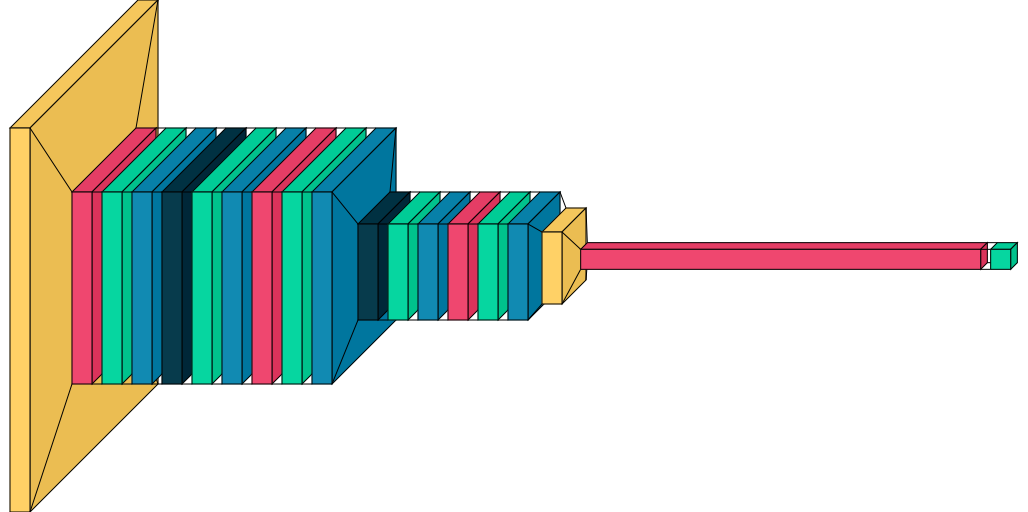

In [ ]:
import visualkeras
visualkeras.layered_view(MobileNetmodelv3_GAN)

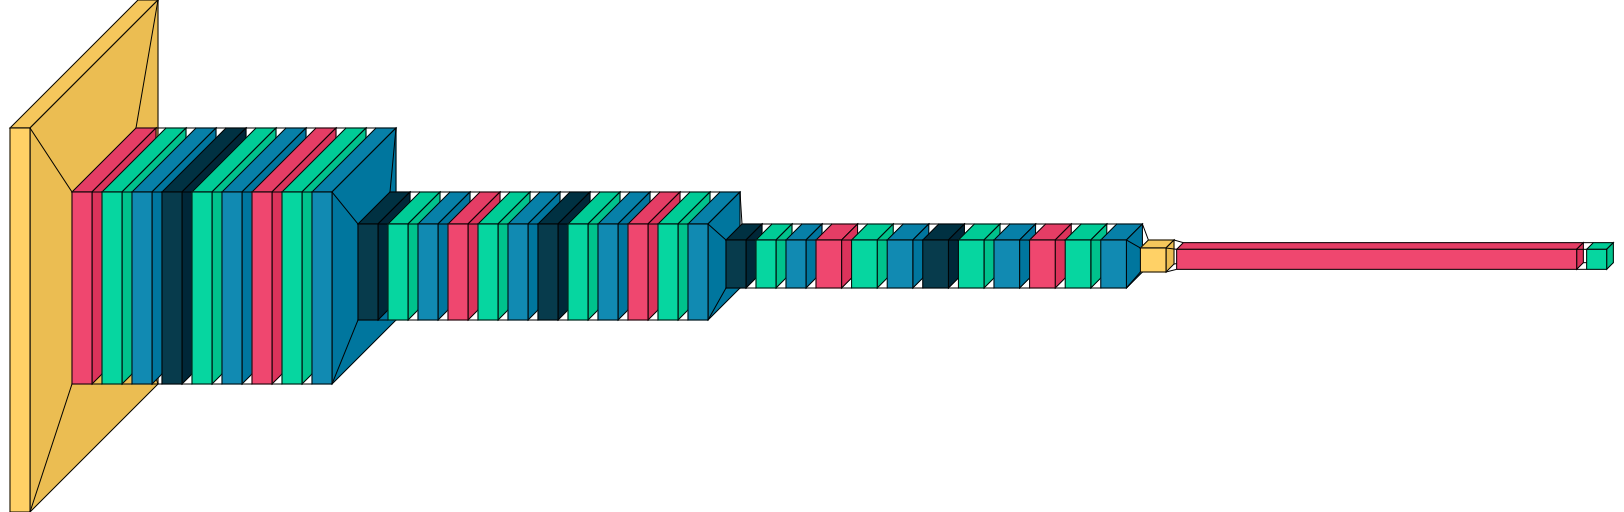

In [ ]:
import visualkeras
visualkeras.layered_view(MobileNetmodelv4_GAN)

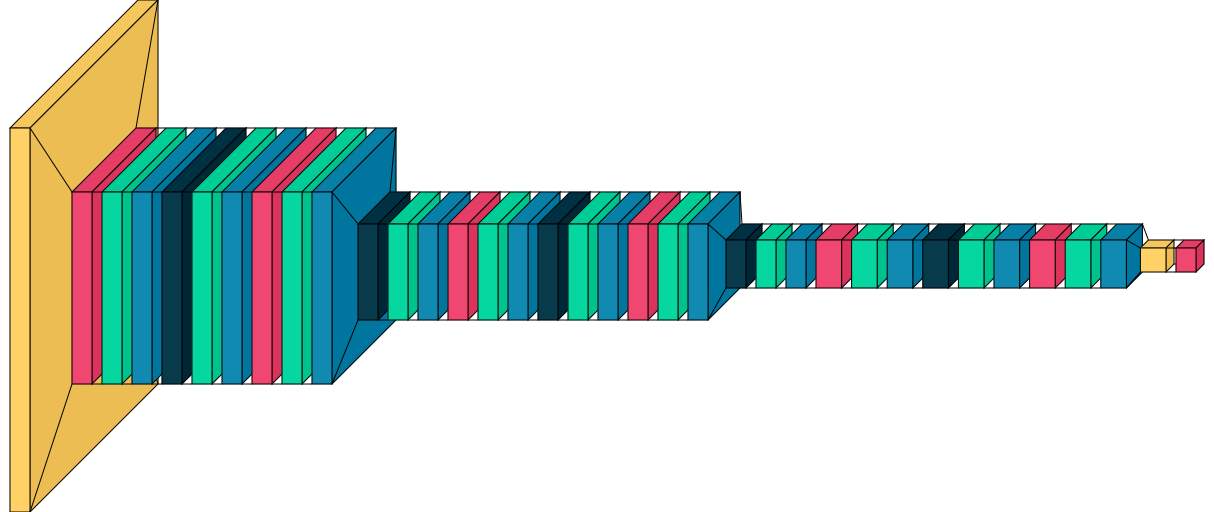

In [ ]:
import visualkeras
visualkeras.layered_view(MobileNetmodelv5_GAN)

In [ ]:
def train_model_mobilenet():
  
  # model = create_model()
  MobileNetmodel_v1.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "MobileNetmodel_v1",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  MobileNetmodel_v1.fit(x=X_GANtrain, 
            y=y_GANtrain, 
            epochs=20, 
            validation_data=(X_GANtest, y_GANtest), 
            callbacks=[tensorboard_callback])

train_model_mobilenet()

Epoch 1/20


InvalidArgumentError: ignored

In [ ]:
def train_model():
  
  # model = create_model()
  Alexnet_model_GAN.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "inception_model_GAN",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  Alexnet_model_GAN.fit(x=X_GANtrain, 
            y=y_GANtrain, 
            epochs=15, 
            validation_data=(X_GANtest, y_GANtest), 
            callbacks=[tensorboard_callback])

train_model()

Epoch 1/15
75/75 [==============================] - 18s 232ms/step - loss: 11.5584 - accuracy: 0.6193 - val_loss: 0.5715 - val_accuracy: 0.7186
Epoch 2/15
75/75 [==============================] - 16s 215ms/step - loss: 0.5504 - accuracy: 0.7315 - val_loss: 0.4268 - val_accuracy: 0.8000
Epoch 3/15
75/75 [==============================] - 15s 198ms/step - loss: 0.3954 - accuracy: 0.8160 - val_loss: 0.3489 - val_accuracy: 0.8480
Epoch 4/15
75/75 [==============================] - 14s 185ms/step - loss: 0.3508 - accuracy: 0.8580 - val_loss: 0.2819 - val_accuracy: 0.8931
Epoch 5/15
75/75 [==============================] - 14s 193ms/step - loss: 0.2895 - accuracy: 0.8874 - val_loss: 0.2784 - val_accuracy: 0.9020
Epoch 6/15
75/75 [==============================] - 14s 185ms/step - loss: 0.2172 - accuracy: 0.9164 - val_loss: 0.2420 - val_accuracy: 0.9039
Epoch 7/15
75/75 [==============================] - 14s 191ms/step - loss: 0.1658 - accuracy: 0.9424 - val_loss: 0.1982 - val_accuracy: 0.925

In [ ]:
# extract the predicted probabilities
p_pred_GANtrain = MobileNetmodelv3_GAN.predict(X_GANtrain)

In [ ]:
y_pred_GANtrain = np.where(p_pred_GANtrain > 0.5, 1, 0)
print(y_pred_GANtrain)

[[0 1]
 [0 1]
 [0 1]
 ...
 [0 1]
 [1 0]
 [1 0]]


In [ ]:
y_GANtrain = to_categorical(y_GANtrain, num_classes= 2)

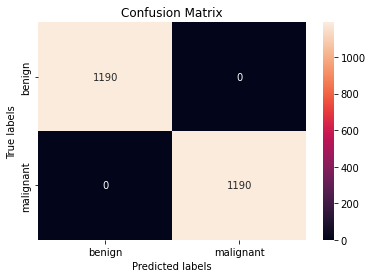

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_GANtrain).argmax(axis=1), np.asarray(y_GANtrain).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
# extract the predicted probabilities
p_pred_GANtest = MobileNetmodelv3_GAN.predict(X_GANtest)

In [ ]:
y_pred_GANtest = np.where(p_pred_GANtest > 0.5, 1, 0)
print(y_pred_GANtest)

[[1 0]
 [1 0]
 [0 1]
 ...
 [1 0]
 [1 0]
 [0 1]]


In [ ]:
y_GANtest = to_categorical(y_GANtest, num_classes= 2)

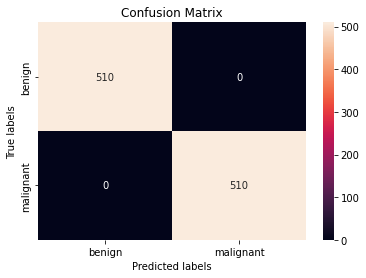

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_GANtest).argmax(axis=1), np.asarray(y_GANtest).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
GAN_Noncancer = np.load('/content/drive/My Drive/yazy/noncancer_lung_04Jun/output/generated_noncancer_nodules_2k_96x96.npy')
GAN_Cancer = np.load('/content/drive/MyDrive/yazy/cancer_lung_29May/output/generated_cancer_nodules_2k_96x96.npy')
print(GAN_Cancer.shape,GAN_Noncancer.shape,GAN_Cancer[0].shape,GAN_Noncancer[0].shape)

(2000, 96, 96, 3) (2000, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
testing_GAN_Cancer = GAN_Cancer[1700:]
testing_GAN_Noncancer = GAN_Noncancer[1700:]
print(testing_GAN_Cancer.shape,testing_GAN_Noncancer.shape,testing_GAN_Cancer[0].shape,testing_GAN_Noncancer[0].shape)

(300, 96, 96, 3) (300, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
X_GAN_testing = np.concatenate((testing_GAN_Cancer, testing_GAN_Noncancer), axis = 0)
Y_GAN_testing = np.concatenate((np.ones(300), np.zeros(300)), axis = 0)
print(X_GAN_testing.shape, Y_GAN_testing.shape)

(600, 96, 96, 3) (600,)


In [ ]:
# extract the predicted probabilities
p_predGAN_testing = MobileNetmodelv3_GAN.predict(X_GAN_testing)

In [ ]:
y_pred_GANtesting = np.where(p_predGAN_testing > 0.5, 1, 0)
print(y_pred_GANtesting)

[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [ ]:
Y_GAN_testing = to_categorical(Y_GAN_testing, num_classes= 2)

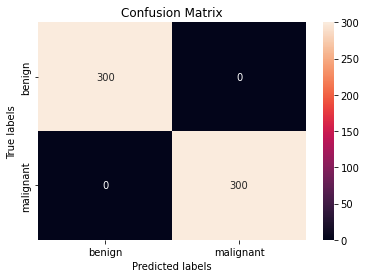

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred_GANtesting).argmax(axis=1), np.asarray(Y_GAN_testing).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
y_GANtrain = to_categorical(y_GANtrain, num_classes= 2)

In [ ]:
from sklearn.metrics import roc_curve
y_pred_GAN = MobileNetmodelv4_GAN.predict(X_GANtrain)
fpr_GAN, tpr_GAN, thresholds_GAN = roc_curve(np.asarray(y_GANtrain).argmax(axis=1), np.asarray(y_pred_GAN).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_GAN = auc(fpr_GAN, tpr_GAN)

In [ ]:
y_GANtest = to_categorical(y_GANtest, num_classes= 2)

In [ ]:
from sklearn.metrics import roc_curve
y_test_GAN = MobileNetmodelv4_GAN.predict(X_GANtest)
fprtest_GAN, tprtest_GAN, thresholdstest_GAN = roc_curve(np.asarray(y_GANtest).argmax(axis=1), np.asarray(y_test_GAN).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auctest_GAN = auc(fprtest_GAN, tprtest_GAN)

In [ ]:
Y_GAN_testing = to_categorical(Y_GAN_testing, num_classes= 2)

In [ ]:
from sklearn.metrics import roc_curve
y_testing_GAN = MobileNetmodelv4_GAN.predict(X_GAN_testing)
fpr_GAN_testing, tpr_GAN_testing, thresholds_GAN_testing = roc_curve(np.asarray(Y_GAN_testing).argmax(axis=1), np.asarray(y_testing_GAN).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_GAN_testing = auc(fpr_GAN_testing, tpr_GAN_testing)

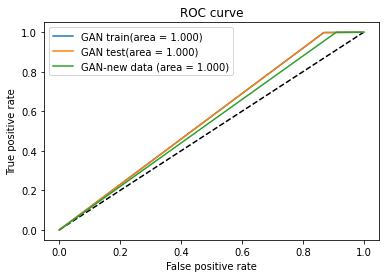

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='GAN train(area = {:.3f})'.format(auc_GAN))
plt.plot(fpr_keras, tpr_keras, label='GAN test(area = {:.3f})'.format(auctest_GAN))
plt.plot(fpr_rf, tpr_rf, label='GAN-new data (area = {:.3f})'.format(auc_GAN_testing))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# plt.figure(2)
# plt.plot([0, 1], [0, 1], 'k--')
# #plt.plot(fpr_keras, tpr_keras, label='GAN train(area = {:.3f})'.format(auc_GAN))
# plt.plot(fpr_keras, tpr_keras, label='GAN test(area = {:.3f})'.format(auctest_GAN))
# plt.plot(fpr_rf, tpr_rf, label='GAN-new data (area = {:.3f})'.format(auc_GAN_testing))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()
# plt.figure(3)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='GAN train(area = {:.3f})'.format(auc_GAN))
# plt.plot(fpr_keras, tpr_keras, label='GAN test(area = {:.3f})'.format(auctest_GAN))
# plt.plot(fpr_rf, tpr_rf, label='GAN-new data (area = {:.3f})'.format(auc_GAN_testing))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()
# # Zoom in view of the upper left corner.
# plt.figure(4)
# plt.xlim(0,0.2)
# plt.ylim(0.6,1.0)
# plt.plot([0, 2], [0, 2], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='GAN train (area = {:.3f})'.format(auc_GAN))
# plt.plot(fpr_keras, tpr_keras, label='GAN test (area = {:.3f})'.format(auctest_GAN))
# plt.plot(fpr_rf, tpr_rf, label='GAN-new data (area = {:.3f})'.format(auc_GAN_testing))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

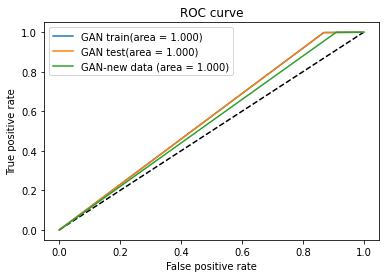

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='GAN train(area = {:.3f})'.format(auc_GAN))
plt.plot(fpr_keras, tpr_keras, label='GAN test(area = {:.3f})'.format(auctest_GAN))
plt.plot(fpr_rf, tpr_rf, label='GAN-new data (area = {:.3f})'.format(auc_GAN_testing))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# plt.figure(2)
# plt.plot([0, 1], [0, 1], 'k--')
# #plt.plot(fpr_keras, tpr_keras, label='GAN train(area = {:.3f})'.format(auc_GAN))
# plt.plot(fpr_keras, tpr_keras, label='GAN test(area = {:.3f})'.format(auctest_GAN))
# plt.plot(fpr_rf, tpr_rf, label='GAN-new data (area = {:.3f})'.format(auc_GAN_testing))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()
# plt.figure(3)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='GAN train(area = {:.3f})'.format(auc_GAN))
# plt.plot(fpr_keras, tpr_keras, label='GAN test(area = {:.3f})'.format(auctest_GAN))
# plt.plot(fpr_rf, tpr_rf, label='GAN-new data (area = {:.3f})'.format(auc_GAN_testing))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()
# # Zoom in view of the upper left corner.
# plt.figure(4)
# plt.xlim(0,0.2)
# plt.ylim(0.6,1.0)
# plt.plot([0, 2], [0, 2], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='GAN train (area = {:.3f})'.format(auc_GAN))
# plt.plot(fpr_keras, tpr_keras, label='GAN test (area = {:.3f})'.format(auctest_GAN))
# plt.plot(fpr_rf, tpr_rf, label='GAN-new data (area = {:.3f})'.format(auc_GAN_testing))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

In [ ]:
!tensorboard dev upload --logdir logs


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=4t6gDy7YqkV8uG4FsaeTj85aOvByAl&prompt=consent&access_type=offline
Enter th

In [ ]:
GAN_Noncancer = np.load('/content/drive/My Drive/yazy/noncancer_lung_04Jun/output/generated_noncancer_nodules_2k_96x96.npy')
GAN_Cancer = np.load('/content/drive/MyDrive/yazy/cancer_lung_29May/output/generated_cancer_nodules_2k_96x96.npy')
print(GAN_Cancer.shape,GAN_Noncancer.shape,GAN_Cancer[0].shape,GAN_Noncancer[0].shape)

(2000, 96, 96, 3) (2000, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
test_GAN_non_cancer_data = GAN_Noncancer[1800:2000]
test_GAN_cancer_data = GAN_Cancer[1800:2000]
print(test_GAN_non_cancer_data.shape,test_GAN_cancer_data.shape,test_GAN_non_cancer_data[0].shape,test_GAN_cancer_data[0].shape)

(200, 96, 96, 3) (200, 96, 96, 3) (96, 96, 3) (96, 96, 3)


In [ ]:
X_GAN_testing = np.concatenate((test_GAN_non_cancer_data,test_GAN_cancer_data), axis = 0)
print(X_GAN_testing.shape, X_GAN_testing[0].shape)

(400, 96, 96, 3) (96, 96, 3)


In [ ]:
GANcancer_labels = np.ones(200)
GANnoncancer_labels = np.zeros(200)
Y_GAN_testing = np.concatenate((GANnoncancer_labels,GANcancer_labels), axis = 0)
print(X_GAN_testing.shape, Y_GAN_testing.shape)

(400, 96, 96, 3) (400,)


In [ ]:
Y_GAN_testing = to_categorical(Y_GAN_testing, num_classes= 2)
print(Y_GAN_testing.shape)

(400, 2)


In [ ]:
y_test = to_categorical(y_test, num_classes= 2)
print(y_test.shape)

(1020, 2)


In [ ]:
# extract the predicted probabilities
p_pred = inception_model.predict(X_GAN_testing)

In [ ]:
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]

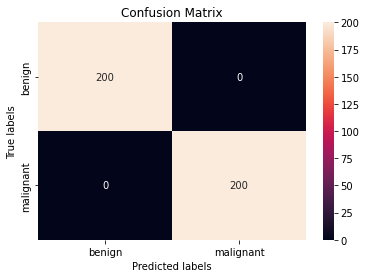

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred).argmax(axis=1), np.asarray(Y_GAN_testing).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = inception_model.predict(X_GAN_testing).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(np.asarray(Y_GAN_testing).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
# extract the predicted probabilities
p_pred = inception_model.predict(X_luna_test)

In [ ]:
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]

In [ ]:
X_luna_test.shape

(480, 96, 96, 3)

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = inception_model.predict(X_luna_test).ravel()
fpr_rf, tpr_rf, thresholds_rf = roc_curve(np.asarray(y_luna_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
auc_rf = auc(fpr_rf, tpr_rf)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

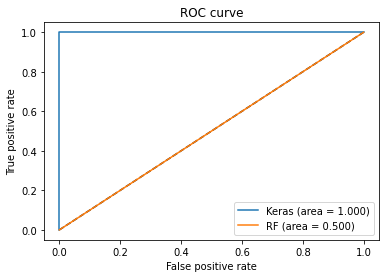

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

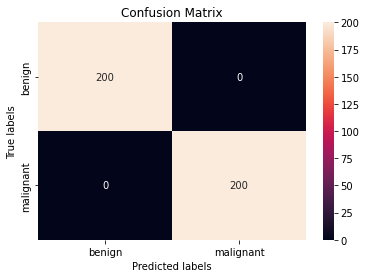

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred).argmax(axis=1), np.asarray(Y_GAN_testing).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
lunas_cancer_data = np.load('/content/drive/MyDrive/Ramasubramanya/LotusFeet/cancernodule_image_900_96_96_patches.npy')
lunas_cancer_data = lunas_cancer_data[800:]
print(lunas_cancer_data.shape, lunas_cancer_data[0].shape)

(900, 96, 96, 1) (96, 96, 1)


In [ ]:
lunas_cancer_data = lunas_cancer_data.reshape(100,96,96)
lunas_cancer_data_rgb = np.repeat(lunas_cancer_data[..., np.newaxis], 3, -1)
print(lunas_cancer_data_rgb.shape, lunas_cancer_data_rgb[0].shape)

(100, 96, 96, 3) (96, 96, 3)


In [ ]:
lunas_non_cancer_data = np.load("/content/drive/MyDrive/Ramasubramanya/LotusFeet/non_cancernodule_image_1400_96_96_patches.npy")
lunas_non_cancer_data = lunas_non_cancer_data[800:900]
print(lunas_non_cancer_data.shape, lunas_non_cancer_data[0].shape)

(100, 96, 96, 1) (96, 96, 1)


In [ ]:
lunas_non_cancer_data = lunas_non_cancer_data.reshape(100,96,96)
lunas_non_cancer_data_rgb = np.repeat(lunas_non_cancer_data[..., np.newaxis], 3, -1)
print(lunas_non_cancer_data_rgb.shape, lunas_non_cancer_data_rgb[0].shape)

(100, 96, 96, 3) (96, 96, 3)


In [ ]:
X_luna = np.concatenate((lunas_cancer_data_rgb,lunas_non_cancer_data_rgb), axis = 0)
print(X_luna.shape, X_luna[0].shape)

(200, 96, 96, 3) (96, 96, 3)


In [ ]:
cancer_labels = np.ones(100)
noncancer_labels = np.zeros(100)
Y_luna = np.concatenate((cancer_labels,noncancer_labels), axis = 0)

print(X_luna.shape, Y_luna.shape)


(200, 96, 96, 3) (200,)


In [ ]:
from sklearn.model_selection import train_test_split
(X_lunas_train, X_lunas_test, y_lunas_train, y_lunas_test) = train_test_split(X_luna, Y_luna,test_size=0.3, stratify=Y_luna, random_state=42)

In [ ]:
print(X_lunas_train.shape, X_lunas_test.shape, y_lunas_train.shape, y_lunas_test.shape)

(140, 96, 96, 3) (60, 96, 96, 3) (140,) (60,)


In [ ]:
# extract the predicted probabilities
p_pred = inception_model.predict(X_luna)

In [ ]:
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]

In [ ]:
Y_luna = to_categorical(Y_luna, num_classes= 2)

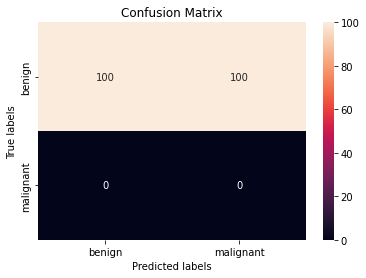

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred).argmax(axis=1), np.asarray(Y_luna).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

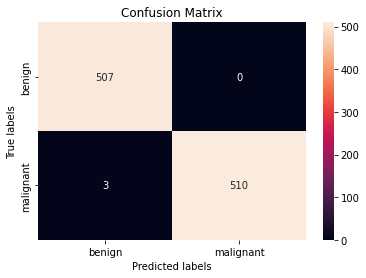

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_pred).argmax(axis=1), np.asarray(y_test).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
# extract the predicted probabilities
p_pred = inception_model.predict(X_GAN_testing)

In [ ]:
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)

[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]

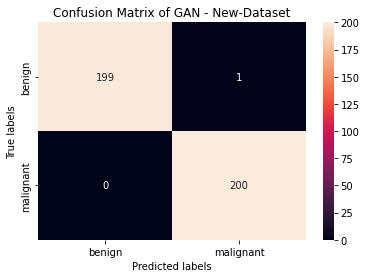

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(Y_GAN_testing).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of GAN - New-Dataset'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);


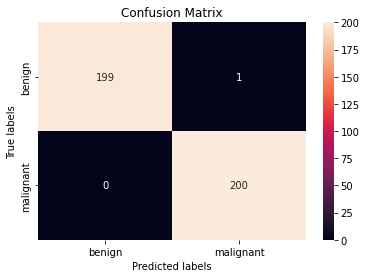

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(Y_GAN_testing).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);


In [ ]:
luna_cancer_datas = np.load('/content/drive/MyDrive/Ramasubramanya/LotusFeet/cancernodule_image_900_96_96_patches.npy')
print(luna_cancer_datas.shape, luna_cancer_datas[0].shape)

(900, 96, 96, 1) (96, 96, 1)


In [ ]:
luna_cancer_datas = luna_cancer_datas[800:]
print(luna_cancer_datas.shape, luna_cancer_datas[0].shape)

(100, 96, 96, 1) (96, 96, 1)


In [ ]:
luna_cancer_datas = luna_cancer_datas.reshape(100,96,96)
luna_cancer_datas_rgb = np.repeat(luna_cancer_datas[..., np.newaxis], 3, -1)
print(luna_cancer_datas_rgb.shape, luna_cancer_datas_rgb[0].shape)

(100, 96, 96, 3) (96, 96, 3)


In [ ]:
luna_non_cancer_datas = np.load("/content/drive/MyDrive/Ramasubramanya/LotusFeet/non_cancernodule_image_1400_96_96_patches.npy")
print(luna_non_cancer_datas.shape, luna_non_cancer_datas[0].shape)

(1400, 96, 96, 1) (96, 96, 1)


In [ ]:
luna_non_cancer_datas = luna_non_cancer_datas[800:900]
print(luna_non_cancer_datas.shape, luna_non_cancer_datas[0].shape)

(100, 96, 96, 1) (96, 96, 1)


In [ ]:
luna_non_cancer_datas = luna_non_cancer_datas.reshape(100,96,96)
luna_non_cancer_datas_rgb = np.repeat(luna_non_cancer_datas[..., np.newaxis], 3, -1)
print(luna_non_cancer_datas_rgb.shape, luna_non_cancer_datas_rgb[0].shape)

(100, 96, 96, 3) (96, 96, 3)


In [ ]:
X_lunas = np.concatenate((luna_cancer_datas_rgb,luna_non_cancer_datas_rgb), axis = 0)
print(X_lunas.shape, X_lunas[0].shape)

(200, 96, 96, 3) (96, 96, 3)


In [ ]:
lunas_cancer_data_labels = np.ones(100)
lunas_non_cancer_data_labels = np.zeros(100)
Y_lunas = np.concatenate((lunas_cancer_data_labels,lunas_non_cancer_data_labels), axis = 0)
print(Y_lunas.shape)

(200,)


In [ ]:
# To categorical
Y_lunas = to_categorical(Y_lunas, num_classes= 2)
print(Y_lunas.shape)

(200, 2)


In [ ]:
from sklearn.model_selection import train_test_split
(X_lunas_train, X_lunas_test, y_lunas_train, y_lunas_test) = train_test_split(X_lunas, Y_lunas,test_size=0.3, stratify=Y_lunas, random_state=42)

In [ ]:
print(X_lunas_train.shape, X_lunas_test.shape, y_lunas_train.shape, y_lunas_test.shape)

(140, 96, 96, 3) (60, 96, 96, 3) (140,) (60,)


In [ ]:
def train_model():
  
  # model = create_model()
  inception_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("logs", "inception_model",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  inception_model.fit(x=X_lunas_train, 
            y=y_lunas_train, 
            epochs=10, 
            validation_data=(X_lunas_test, y_lunas_test), 
            callbacks=[tensorboard_callback])

train_model()

Epoch 1/10
5/5 [==============================] - 14s 1s/step - loss: 1.2573 - accuracy: 0.8071 - val_loss: 3.9572 - val_accuracy: 0.5000
Epoch 2/10
5/5 [==============================] - 4s 1s/step - loss: 0.3665 - accuracy: 0.8143 - val_loss: 102.0470 - val_accuracy: 0.5000
Epoch 3/10
5/5 [==============================] - 4s 1s/step - loss: 0.3416 - accuracy: 0.8500 - val_loss: 5.5247 - val_accuracy: 0.5000
Epoch 4/10
5/5 [==============================] - 4s 1s/step - loss: 0.2411 - accuracy: 0.8929 - val_loss: 3.6018 - val_accuracy: 0.5000
Epoch 5/10
5/5 [==============================] - 4s 1s/step - loss: 0.1631 - accuracy: 0.9286 - val_loss: 1.4797 - val_accuracy: 0.5000
Epoch 6/10
5/5 [==============================] - 4s 1s/step - loss: 0.1142 - accuracy: 0.9714 - val_loss: 1.0639 - val_accuracy: 0.5000
Epoch 7/10
5/5 [==============================] - 4s 1s/step - loss: 0.1443 - accuracy: 0.9571 - val_loss: 0.8660 - val_accuracy: 0.5000
Epoch 8/10
5/5 [======================

In [ ]:
# To categorical
y_lunas_train = to_categorical(y_lunas_train, num_classes= 2)
y_lunas_test = to_categorical(y_lunas_test, num_classes= 2)

In [ ]:
# extract the predicted probabilities
p_pred = inception_model.predict(X_lunas_train)

In [ ]:
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)

[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]


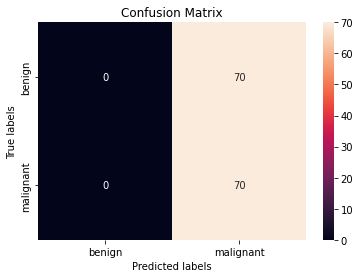

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

T5_lables = ['benign','malignant']    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_lunas_train).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [ ]:
from sklearn.metrics import roc_curve
y_pred_GAN = inception_model.predict(X_GANtrain)
fpr_GAN, tpr_GAN, thresholds_GAN = roc_curve(np.asarray(y_GANtrain).argmax(axis=1), np.asarray(y_pred_GAN).argmax(axis=1))

AxisError: ignored

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
